# Mount google drive

Follow instructions:  
- paste url in a browser
- log in and get an authorization code
- paste authorization code here
- On the File browser (left), click refresh and you should see a drive directory: /content/drive/My Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
############################################################################## UTILS

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow.compat.v1.keras.backend as K1


def make_directory(path, foldername, verbose=1):
    """make a directory"""

    if not os.path.isdir(path):
        os.mkdir(path)
        print("making directory: " + path)

    outdir = os.path.join(path, foldername)
    if not os.path.isdir(outdir):
        os.mkdir(outdir)
        print("making directory: " + outdir)
    return outdir

    
def run_function_batch(sess, signed_grad, model, placeholders, inputs, batch_size=128):
    
    def feed_dict_batch(placeholders, inputs, index):
        feed_dict = {}
        for i in range(len(placeholders)):
            feed_dict[placeholders[i]] = inputs[i][index]
        return feed_dict
    
    N = len(inputs[0])
    num_batches = int(np.floor(N/batch_size))
    
    values = []
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)
        values.append(sess.run(signed_grad, feed_dict_batch(placeholders, inputs, index)))
    if num_batches*batch_size < N:
        index = range(num_batches*batch_size, N)
        values.append(sess.run(signed_grad, feed_dict_batch(placeholders, inputs, index)))
    values = np.concatenate(values, axis=0)

    return values


def calculate_class_weight(y_train):
    # calculate class weights
    count = np.sum(y_train, axis=0)
    weight = np.sqrt(np.max(count)/count)
    class_weight = {}
    for i in range(y_train.shape[1]):
        class_weight[i] = weight[i]
    return class_weight
    

def compile_regression_model(model, learning_rate=0.001, mask_val=None, **kwargs):

    optimizer = optimizers(optimizer=optimizer, learning_rate=learning_rate, **kwargs)

    if mask:
        def masked_loss_function(y_true, y_pred):
            mask = tf.cast(tf.math.logical_not(tf.math.equal(y_true, mask_val)), dtype=tf.float32)
            return keras.losses.mean_squared_error(y_true*mask, y_pred*mask)
        loss = masked_loss_function
    else:
        loss = keras.losses.mean_squared_error

    model.compile(optimizer=optimizer, loss=loss)



def compile_classification_model(model, loss_type='binary', optimizer='adam', 
                                 learning_rate=0.001, monitor=['acc', 'auroc', 'aupr'], 
                                 label_smoothing=0.0, from_logits=False, **kwargs):

    optimizer = optimizers(optimizer=optimizer, learning_rate=learning_rate, **kwargs)

    metrics = []
    if 'acc' in monitor:    
        metrics.append('accuracy')
    if 'auroc' in monitor:
        metrics.append(keras.metrics.AUC(curve='ROC', name='auroc'))
    if 'auroc' in monitor:
        metrics.append(keras.metrics.AUC(curve='PR', name='aupr'))

    if loss_type == 'binary':
        loss = keras.losses.BinaryCrossentropy(from_logits=from_logits, label_smoothing=label_smoothing)
    elif loss_type == 'categorical':
        loss = keras.losses.CategoricalCrossentropy(from_logits=from_logits, label_smoothing=label_smoothing)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)



def optimizers(optimizer='adam', learning_rate=0.001, **kwargs):

    if optimizer == 'adam':
        if 'beta_1' in kwargs.keys():
            beta_1 = kwargs['beta_1']
        else:
            beta_1 = 0.9
        if 'beta_2' in kwargs.keys():
            beta_2 = kwargs['beta_2']
        else:
            beta_2 = 0.999
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

    elif optimizer == 'sgd':
        if 'momentum' in kwargs.keys():
            momentum = kwargs['momentum']
        else:
            momentum = 0.0
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    return optimizer



def clip_filters(W, threshold=0.5, pad=3):

    W_clipped = []
    for w in W:
        L,A = w.shape
        entropy = np.log2(4) + np.sum(w*np.log2(w+1e-7), axis=1)
        index = np.where(entropy > threshold)[0]
        if index.any():
            start = np.maximum(np.min(index)-pad, 0)
            end = np.minimum(np.max(index)+pad+1, L)
            W_clipped.append(w[start:end,:])
        else:
            W_clipped.append(w)

    return W_clipped



def meme_generate(W, output_file='meme.txt', prefix='filter'):

    # background frequency
    nt_freqs = [1./4 for i in range(4)]

    # open file for writing
    f = open(output_file, 'w')

    # print intro material
    f.write('MEME version 4\n')
    f.write('\n')
    f.write('ALPHABET= ACGT\n')
    f.write('\n')
    f.write('Background letter frequencies:\n')
    f.write('A %.4f C %.4f G %.4f T %.4f \n' % tuple(nt_freqs))
    f.write('\n')

    for j, pwm in enumerate(W):
        L, A = pwm.shape
        f.write('MOTIF %s%d \n' % (prefix, j))
        f.write('letter-probability matrix: alength= 4 w= %d nsites= %d \n' % (L, L))
        for i in range(L):
            f.write('%.4f %.4f %.4f %.4f \n' % tuple(pwm[i,:]))
        f.write('\n')

    f.close()



def match_hits_to_ground_truth(file_path, motifs, size=30):
    
    # get dataframe for tomtom results
    df = pd.read_csv(file_path, delimiter='\t')

    # loop through filters
    best_qvalues = np.ones(size)
    best_match = np.zeros(size)
    for name in np.unique(df['Query_ID'].as_matrix()):

        if name[:6] == 'filter':
            filter_index = int(name.split('r')[1])

            # get tomtom hits for filter
            subdf = df.loc[df['Query_ID'] == name]
            targets = subdf['Target_ID'].as_matrix()

            # loop through ground truth motifs
            for k, motif in enumerate(motifs): 

                # loop through variations of ground truth motif
                for motifid in motif: 

                    # check if there is a match
                    index = np.where((targets == motifid) ==  True)[0]
                    if len(index) > 0:
                        qvalue = subdf['q-value'].as_matrix()[index]

                        # check to see if better motif hit, if so, update
                        if best_qvalues[filter_index] > qvalue:
                            best_qvalues[filter_index] = qvalue
                            best_match[filter_index] = k 

    # get the minimum q-value for each motif
    min_qvalue = np.zeros(13)
    for i in range(13):
        index = np.where(best_match == i)[0]
        if len(index) > 0:
            min_qvalue[i] = np.min(best_qvalues[index])

    match_index = np.where(best_qvalues != 1)[0]
    match_fraction = len(match_index)/float(size)

    return best_qvalues, best_match, min_qvalue, match_fraction 



def activation_fn(activation):
    
    if activation == 'exp_relu':
        return exp_relu
    elif activation == 'shift_scale_tanh':
        return shift_scale_tanh
    elif activation == 'shift_scale_relu':
        return shift_scale_relu
    elif activation == 'shift_scale_sigmoid':
        return shift_scale_sigmoid
    elif activation == 'shift_relu':
        return shift_relu
    elif activation == 'shift_sigmoid':
        return shift_sigmoid
    elif activation == 'shift_tanh':
        return shift_tanh
    elif activation == 'scale_relu':
        return scale_relu
    elif activation == 'scale_sigmoid':
        return scale_sigmoid
    elif activation == 'scale_tanh':
        return scale_tanh
    elif activation == 'log_relu':
        return log_relu
    elif activation == 'log':
        return log
    elif activation == 'exp':
        return 'exponential'
    else:
        return activation
        
def exp_relu(x, beta=0.001):
    return K.relu(K.exp(.1*x)-1)

def log(x):
    return K.log(K.abs(x) + 1e-10)

def log_relu(x):
    return K.relu(K.log(K.abs(x) + 1e-10))

def shift_scale_tanh(x):
    return K.tanh(x-6.0)*500 + 500

def shift_scale_sigmoid(x):
    return K.sigmoid(x-8.0)*4000

def shift_scale_relu(x):
    return K.relu(K.pow(x-0.2, 3))

def shift_tanh(x):
    return K.tanh(x-6.0)

def shift_sigmoid(x):
    return K.sigmoid(x-8.0)

def shift_relu(x):
    return K.relu(x-0.2)

def scale_tanh(x):
    return K.tanh(x)*500 + 500

def scale_sigmoid(x):
    return K.sigmoid(x)*4000

def scale_relu(x):
    return K.relu((x)**3)

In [ ]:
################################################################################ LAYERS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.layers import Layer


def dense_layer(input_layer, num_units, activation, dropout=0.5, l2=None, bn=True, kernel_initializer=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    nn = keras.layers.Dense(num_units, 
                            activation=None, 
                            use_bias=False,  
                            kernel_initializer=kernel_initializer,
                            bias_initializer='zeros', 
                            kernel_regularizer=l2, 
                            bias_regularizer=None,
                            activity_regularizer=None, 
                            kernel_constraint=None, 
                            bias_constraint=None)(input_layer)
    if bn:
        nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    if dropout:
        nn = keras.layers.Dropout(dropout)(nn)
        
    return nn


def conv_layer(inputs, num_filters, kernel_size, padding='same', activation='relu', dropout=0.2, l2=None, bn=True, kernel_initializer=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    nn = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=kernel_size,
                             strides=1,
                             activation=None,
                             use_bias=False,
                             padding=padding,
                             kernel_initializer=kernel_initializer,
                             kernel_regularizer=l2, 
                             bias_regularizer=None, 
                             activity_regularizer=None,
                             kernel_constraint=None, 
                             bias_constraint=None,
                             )(inputs)        
    if bn:                      
        nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    if dropout:
        nn = keras.layers.Dropout(dropout)(nn)
    return nn


    
def residual_block(input_layer, filter_size, activation='relu', l2=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    num_filters = input_layer.shape.as_list()[-1]  

    nn = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=filter_size,
                             strides=1,
                             activation='relu',
                             use_bias=False,
                             padding='same',
                             dilation_rate=1,
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2
                             )(input_layer) 
    nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    nn = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=filter_size,
                             strides=1,
                             activation='relu',
                             use_bias=False,
                             padding='same',
                             dilation_rate=1,
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2
                             )(nn) 
    nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.add([input_layer, nn])
    return keras.layers.Activation(activation)(nn)

In [ ]:
################################################################################ METRICS

import numpy as np
from scipy import stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score


def accuracy(label, prediction):
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    for i in range(num_labels):
        metric[i] = accuracy_score(label[:,i], np.round(prediction[:,i]))
    return metric


def auroc(label, prediction):
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    for i in range(num_labels):
        fpr, tpr, thresholds = roc_curve(label[:,i], prediction[:,i])
        score = auc(fpr, tpr)
        metric[i]= score
    return metric


def aupr(label, prediction):
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    for i in range(num_labels):
        precision, recall, thresholds = precision_recall_curve(label[:,i], prediction[:,i])
        score = auc(recall, precision)
        metric[i] = score
    return metric


def pearsonr(label, prediction, mask_value=None):
    num_labels = label.shape[1]
    corr = np.zeros((num_labels))
    for i in range(num_labels):
        if mask_value:
            index = np.where(label[:,i] != mask_value)[0]
            corr[i] = stats.pearsonr(label[index,i], prediction[index,i])[0]
        else:
            corr[i] = stats.pearsonr(label[:,i], prediction[:,i])[0]

    return corr


def rsquare(label, prediction):  
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    slope = np.zeros((num_labels))
    for i in range(num_labels):
        y = label[:,i]
        X = prediction[:,i]
        m = np.dot(X,y)/np.dot(X, X)
        resid = y - m*X; 
        ym = y - np.mean(y); 
        rsqr2 = 1 - np.dot(resid.T,resid)/ np.dot(ym.T, ym);
        metric[i] = rsqr2
        slope[i] = m
    return metric, slope



def calculate_metrics(label, prediction, objective):
    """calculate metrics for classification"""

    if (objective == "binary"):
        acc = accuracy(label, prediction)
        auc_roc = auroc(label, prediction)
        auc_pr = aupr(label, prediction)
        mean = [np.nanmean(acc), np.nanmean(auc_roc), np.nanmean(auc_pr)]
        std = [np.nanstd(acc), np.nanstd(auc_roc), np.nanstd(auc_pr)]

    elif objective == "categorical":
        acc = np.mean(np.equal(np.argmax(label, axis=1), np.argmax(prediction, axis=1)))
        auc_roc = auroc(label, prediction)
        auc_pr = aupr(label, prediction)
        mean = [np.nanmean(acc), np.nanmean(auc_roc), np.nanmean(auc_pr)]
        std = [np.nanstd(acc), np.nanstd(auc_roc), np.nanstd(auc_pr)]

    elif (objective == 'squared_error'):
        corr = pearsonr(label,prediction)
        rsqr, slope = rsquare(label, prediction)
        mean = [np.nanmean(corr), np.nanmean(rsqr), np.nanmean(slope)]
        std = [np.nanstd(corr), np.nanstd(rsqr), np.nanstd(slope)]

    else:
        mean = 0
        std = 0

    return [mean, std]

In [ ]:
################################################################################# HELPER for Task3
import os, sys
import h5py
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score
from tensorflow import keras



def load_data(file_path, reverse_compliment=False):

    # load dataset
    dataset = h5py.File(file_path, 'r')
    x_train = np.array(dataset['X_train']).astype(np.float32)
    y_train = np.array(dataset['Y_train']).astype(np.float32)
    x_valid = np.array(dataset['X_valid']).astype(np.float32)
    y_valid = np.array(dataset['Y_valid']).astype(np.float32)
    x_test = np.array(dataset['X_test']).astype(np.float32)
    y_test = np.array(dataset['Y_test']).astype(np.float32)

    x_train = np.squeeze(x_train)
    x_valid = np.squeeze(x_valid)
    x_test = np.squeeze(x_test)

    if reverse_compliment:
        x_train_rc = x_train[:,::-1,:][:,:,::-1]
        x_valid_rc = x_valid[:,::-1,:][:,:,::-1]
        x_test_rc = x_test[:,::-1,:][:,:,::-1]
        
        x_train = np.vstack([x_train, x_train_rc])
        x_valid = np.vstack([x_valid, x_valid_rc])
        x_test = np.vstack([x_test, x_test_rc])
        
        y_train = np.vstack([y_train, y_train])
        y_valid = np.vstack([y_valid, y_valid])
        y_test = np.vstack([y_test, y_test])
        
    x_train = x_train.transpose([0,2,1])
    x_valid = x_valid.transpose([0,2,1])
    x_test = x_test.transpose([0,2,1])

    return x_train, y_train, x_valid, y_valid, x_test, y_test



def load_synthetic_models(filepath, dataset='test'):
    # setup paths for file handling

    trainmat = h5py.File(filepath, 'r')
    if dataset == 'train':
        return np.array(trainmat['model_train']).astype(np.float32)
    elif dataset == 'valid':
        return np.array(trainmat['model_valid']).astype(np.float32)
    elif dataset == 'test':
        return np.array(trainmat['model_test']).astype(np.float32)


def load_basset_dataset(filepath, reverse_compliment=False):

    trainmat = h5py.File(filepath, 'r')

    x_train = np.array(trainmat['train_in']).astype(np.float32)
    y_train = np.array(trainmat['train_out']).astype(np.int32)
    x_valid = np.array(trainmat['valid_in']).astype(np.float32)
    y_valid = np.array(trainmat['valid_out']).astype(np.int32)
    x_test = np.array(trainmat['test_in']).astype(np.float32)
    y_test = np.array(trainmat['test_out']).astype(np.int32)

    x_train = np.squeeze(x_train)
    x_valid = np.squeeze(x_valid)
    x_test = np.squeeze(x_test)

    x_train = x_train.transpose([0,2,1])
    x_valid = x_valid.transpose([0,2,1])
    x_test = x_test.transpose([0,2,1])


    if reverse_compliment:
        x_train_rc = x_train[:,::-1,:][:,:,::-1]
        x_valid_rc = x_valid[:,::-1,:][:,:,::-1]
        x_test_rc = x_test[:,::-1,:][:,:,::-1]
        
        x_train = np.vstack([x_train, x_train_rc])
        x_valid = np.vstack([x_valid, x_valid_rc])
        x_test = np.vstack([x_test, x_test_rc])
        
        y_train = np.vstack([y_train, y_train])
        y_valid = np.vstack([y_valid, y_valid])
        y_test = np.vstack([y_test, y_test])

    return x_train, y_train, x_valid, y_valid, x_test, y_test
    

def load_model(model_name, activation='relu', input_shape=200):

    if model_name == 'cnn-50':
        #from model_zoo import cnn_model
        model = cnn_model.model([50, 2], activation, input_shape)

    elif model_name == 'cnn-2':
        #from model_zoo import cnn_model
        model = cnn_model.model([2, 50], activation, input_shape)

    elif model_name == 'cnn-deep':
        #from model_zoo import cnn_deep
        model = cnn_deep.model(activation, input_shape)

    elif model_name == 'cnn-local':
        #from model_zoo import cnn_local
        model = cnn_local_model(activation)

    elif model_name == 'cnn-dist':
        #from model_zoo import cnn_dist
        model = cnn_dist_model(activation)

    elif model_name == 'basset':
        #from model_zoo import basset
        model = basset.model(activation)

    elif model_name == 'residualbind':
        #from model_zoo import residualbind
        model = residualbind.model(activation)

    return model



def match_hits_to_ground_truth(file_path, motifs, size=32):
    
    # get dataframe for tomtom results
    df = pd.read_csv(file_path, delimiter='\t')
    
    # loop through filters
    best_qvalues = np.ones(size)
    best_match = np.zeros(size)
    correction = 0  
    for name in np.unique(df['Query_ID'][:-3].to_numpy()):
        filter_index = int(name.split('r')[1])

        # get tomtom hits for filter
        subdf = df.loc[df['Query_ID'] == name]
        targets = subdf['Target_ID'].to_numpy()

        # loop through ground truth motifs
        for k, motif in enumerate(motifs): 

            # loop through variations of ground truth motif
            for motifid in motif: 

                # check if there is a match
                index = np.where((targets == motifid) ==  True)[0]
                if len(index) > 0:
                    qvalue = subdf['q-value'].to_numpy()[index]

                    # check to see if better motif hit, if so, update
                    if best_qvalues[filter_index] > qvalue:
                        best_qvalues[filter_index] = qvalue
                        best_match[filter_index] = k 

        index = np.where((targets == 'MA0615.1') ==  True)[0]
        if len(index) > 0:
            if len(targets) == 1:
                correction += 1

    # get the minimum q-value for each motif
    num_motifs = len(motifs)
    min_qvalue = np.zeros(num_motifs)
    for i in range(num_motifs):
        index = np.where(best_match == i)[0]
        if len(index) > 0:
            min_qvalue[i] = np.min(best_qvalues[index])

    match_index = np.where(best_qvalues != 1)[0]
    if any(match_index):
        match_fraction = len(match_index)/float(size)
    else:
        match_fraction = 0
    
    num_matches = len(np.unique(df['Query_ID']))-3
    match_any = (num_matches - correction)/size

    return best_qvalues, best_match, min_qvalue, match_fraction, match_any



        
def interpretability_performance(X, score, X_model):

    score = np.sum(score, axis=2)
    pr_score = []
    roc_score = []
    gt_info_score = []
    for j, gs in enumerate(score):

        # calculate information of ground truth
        gt_info = np.log2(4) + np.sum(X_model[j]*np.log2(X_model[j]+1e-10),axis=0)

        # set label if information is greater than 0
        label = np.zeros(gt_info.shape)
        label[gt_info > 0.1] = 1  #Antonio change, was 0.01

        # precision recall metric
        precision, recall, thresholds = precision_recall_curve(label, gs)
        pr_score.append(auc(recall, precision))

        # roc curve
        fpr, tpr, thresholds = roc_curve(label, gs)
        roc_score.append(auc(fpr, tpr))

        #Antonio
        gt_info_score.append(gt_info)

    roc_score = np.array(roc_score)
    pr_score = np.array(pr_score)

    return roc_score, pr_score , gt_info_score
    


def get_callbacks(monitor='val_auroc', patience=20, decay_patience=5, decay_factor=0.2):
    es_callback = keras.callbacks.EarlyStopping(monitor=monitor, 
                                                patience=patience, 
                                                verbose=1, 
                                                mode='max', 
                                                restore_best_weights=False)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
                                                  factor=decay_factor,
                                                  patience=decay_patience, 
                                                  min_lr=1e-7,
                                                  mode='max',
                                                  verbose=1) 

    return [es_callback, reduce_lr]



def compile_model(model):

    # set up optimizer and metrics
    auroc = keras.metrics.AUC(curve='ROC', name='auroc')
    aupr = keras.metrics.AUC(curve='PR', name='aupr')
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy', auroc, aupr])

In [ ]:
################################################################################### CNN-local and CNN-dist


def cnn_dist_model(activation='relu'):
        
    # input layer
    inputs = keras.layers.Input(shape=(200,4))
    activation = activation_fn(activation)

    # block 1
    nn = conv_layer(inputs,
                           num_filters=24, 
                           kernel_size=19, 
                           padding='same', 
                           activation=activation, 
                           dropout=0.1,
                           l2=1e-6, 
                           bn=True)

    # layer 2
    nn = conv_layer(nn,
                           num_filters=32, 
                           kernel_size=7, 
                           padding='same', 
                           activation='relu', 
                           dropout=0.2,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=4)(nn)

    # layer 3
    nn = conv_layer(nn,
                           num_filters=48, 
                           kernel_size=7, 
                           padding='valid', 
                           activation='relu', 
                           dropout=0.3,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=4)(nn)

    # layer 4
    nn = conv_layer(nn,
                           num_filters=64, 
                           kernel_size=3, 
                           padding='valid', 
                           activation='relu', 
                           dropout=0.4,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=3, 
                                strides=3, 
                                padding='same'
                                )(nn)

    # layer 5
    nn = keras.layers.Flatten()(nn)
    nn = dense_layer(nn, num_units=96, activation='relu', 
                            dropout=0.5, l2=1e-6, bn=True)

    # Output layer 
    logits = keras.layers.Dense(1, activation='linear', use_bias=True)(nn)
    outputs = keras.layers.Activation('sigmoid')(logits)
        
    # compile model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model




def cnn_local_model(activation='relu'):
      
    # input layer
    inputs = keras.layers.Input(shape=(200,4))
    activation = activation_fn(activation)

    # layer 1
    nn = conv_layer(inputs,
                           num_filters=24, 
                           kernel_size=19, 
                           padding='same', 
                           activation=activation, 
                           dropout=0.1,
                           l2=1e-6,
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=50)(nn)

    # layer 2
    nn = conv_layer(nn, 
                           num_filters=48, 
                           kernel_size=3, 
                           padding='same',
                           activation='relu', 
                           dropout=0.2, 
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=2)(nn)

    # layer 3
    nn = keras.layers.Flatten()(nn)
    nn = dense_layer(nn, num_units=96, activation='relu', 
                            dropout=0.5, l2=1e-6, bn=True)

    # Output layer 
    logits = keras.layers.Dense(1, activation='linear', use_bias=True)(nn)
    outputs = keras.layers.Activation('sigmoid')(logits)

    # compile model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
################################################################################## EXPLAIN
import numpy as np
import pandas as pd
#import logomaker
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow.compat.v1.keras.backend as K1
#import shap



def saliency(model, X, class_index=0, layer=-2, batch_size=256):
    saliency = K1.gradients(model.layers[layer].output[:,class_index], model.input)[0]
    sess = K1.get_session()

    N = len(X)
    num_batches = int(np.floor(N/batch_size))

    attr_score = []
    for i in range(num_batches):
        attr_score.append(sess.run(saliency, {model.inputs[0]: X[i*batch_size:(i+1)*batch_size]}))
    if num_batches*batch_size < N:
        attr_score.append(sess.run(saliency, {model.inputs[0]: X[num_batches*batch_size:N]}))

    return np.concatenate(attr_score, axis=0)


def mutagenesis(model, X, class_index=0, layer=-2):

    def generate_mutagenesis(X):
        L,A = X.shape 

        X_mut = []
        for l in range(L):
            for a in range(A):
                X_new = np.copy(X)
                X_new[l,:] = 0
                X_new[l,a] = 1
                X_mut.append(X_new)
        return np.array(X_mut)

    N, L, A = X.shape 
    intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

    attr_score = []
    for x in X:

        # get baseline wildtype score
        wt_score = intermediate.predict(np.expand_dims(x, axis=0))[:, class_index]

        # generate mutagenized sequences
        x_mut = generate_mutagenesis(x)
        
        # get predictions of mutagenized sequences
        predictions = intermediate.predict(x_mut)[:,class_index]

        # reshape mutagenesis predictiosn
        mut_score = np.zeros((L,A))
        k = 0
        for l in range(L):
            for a in range(A):
                mut_score[l,a] = predictions[k]
                k += 1
                
        attr_score.append(mut_score - wt_score)
    return np.array(attr_score)


def deepshap(model, X, class_index=0, layer=-2, num_background=10, reference='shuffle'):

    N, L, A = X.shape 
    if reference is not 'shuffle':
        num_background = 1
        
    # set of background sequences to take expectation over
    shap_values = []
    for j, x in enumerate(X):
        if np.mod(j, 50) == 0:
            print("%d out of %d"%(j,N))
        if reference == 'shuffle':
            background = []
            for i in range(num_background):
                shuffle = np.random.permutation(L)
                background.append(x[shuffle, :])
            background = np.array(background)
        else: 
            background = np.zeros([1,L,A])     

        x = np.expand_dims(x, axis=0)
        # calculate SHAPLEY values 
        background.shape
        e = shap.DeepExplainer(model, background) #shap.DeepExplainer(model, background)
        shap_values.append(e.shap_values(x)[0])

    attr_score = np.concatenate(shap_values, axis=0)
    return attr_score


 

def integrated_grad(model, X, class_index=0, layer=-2, num_background=10, num_steps=20, reference='shuffle'):

    def linear_path_sequences(x, num_background, num_steps, reference):
        def linear_interpolate(x, base, num_steps=20):
            x_interp = np.zeros(tuple([num_steps] +[i for i in x.shape]))
            for s in range(num_steps):
                x_interp[s] = base + (x - base)*(s*1.0/num_steps)
            return x_interp

        L, A = x.shape 
        seq = []
        for i in range(num_background):
            if reference == 'shuffle':
                shuffle = np.random.permutation(L)
                background = x[shuffle, :]
            else: 
                background = np.zeros(x.shape)        
            seq.append(linear_interpolate(x, background, num_steps))
        return np.concatenate(seq, axis=0)

    # setup op to get gradients from class-specific outputs to inputs
    saliency = K1.gradients(model.layers[layer].output[:,class_index], model.input)[0]

    # start session
    sess = K1.get_session()

    attr_score = []
    for x in X:
        # generate num_background reference sequences that follow linear path towards x in num_steps
        seq = linear_path_sequences(x, num_background, num_steps, reference)
       
        # average/"integrate" the saliencies along path -- average across different references
        attr_score.append([np.mean(sess.run(saliency, {model.inputs[0]: seq}), axis=0)])
    attr_score = np.concatenate(attr_score, axis=0)

    return attr_score


    
def attribution_score(model, X, method='saliency', norm='times_input', class_index=0,  layer=-2, **kwargs):   #The method can be changed! 

    N, L, A = X.shape 
    if method == 'saliency':
        if 'batch_size' in kwargs:
            batch_size = kwargs['batch_size']
        else:
            batch_size=256
        
        attr_score = saliency(model, X, class_index, layer, batch_size)

        
    elif method == 'mutagenesis':
        
        attr_score = mutagenesis(model, X, class_index, layer)
        
    elif method == 'deepshap':
        if 'num_background' in kwargs:
            num_background = kwargs['num_background']
        else:
            num_background = 5
        if 'reference' in kwargs:
            reference = kwargs['reference']
        else:
            reference = 'shuffle'
    
        attr_score = deepshap(model, X, class_index, num_background, reference)

        
    elif method == 'integrated_grad':
        if 'num_background' in kwargs:
            num_background = kwargs['num_background']
        else:
            num_background = 10
        if 'num_steps' in kwargs:
            num_steps = kwargs['num_steps']
        else:
            num_steps = 20
        if 'reference' in kwargs:
            reference = kwargs['reference']
        else:
            reference = 'shuffle'
        
        attr_score = integrated_grad(model, X, class_index, layer, num_background, num_steps, reference)

    if norm == 'l2norm':
        attr_score = np.sqrt(np.sum(np.squeeze(attr_score)**2, axis=2, keepdims=True) + 1e-10)
        attr_score =  X * np.matmul(attr_score, np.ones((1, X.shape[-1])))
        
    elif norm == 'times_input':
        attr_score *= X

    return attr_score


#-------------------------------------------------------------------------------------------------
# Plot conv filters
#-------------------------------------------------------------------------------------------------


def plot_filers(model, x_test, layer=3, threshold=0.5, window=20, num_cols=8, figsize=(30,5)):

    intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
    fmap = intermediate.predict(x_test)
    W = activation_pwm(fmap, x_test, threshold=threshold, window=window)

    num_filters = len(W)
    num_widths = int(np.ceil(num_filters/num_cols))

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    logos = []
    for n, w in enumerate(W):
        ax = fig.add_subplot(num_widths, num_cols, n+1)
    
        # calculate sequence logo heights
        I = np.log2(4) + np.sum(w * np.log2(w+1e-10), axis=1, keepdims=True)
        logo = np.maximum(I*w, 1e-7)

        L, A = w.shape
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = logo[l,a]

        logomaker.Logo(counts_df, ax=ax)
        ax = plt.gca()
        ax.set_ylim(0,2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
    
        logos.append(logo)
        
    return fig, W, logo



def activation_pwm(fmap, X, threshold=0.5, window=20):

    # extract sequences with aligned activation
    window_left = int(window/2)
    window_right = window - window_left

    N,L,A = X.shape
    num_filters = fmap.shape[-1]

    W = []
    for filter_index in range(num_filters):

        # find regions above threshold
        coords = np.where(fmap[:,:,filter_index] > np.max(fmap[:,:,filter_index])*threshold)

        if len(coords) > 1:
            x, y = coords

            # sort score
            index = np.argsort(fmap[x,y,filter_index])[::-1]
            data_index = x[index].astype(int)
            pos_index = y[index].astype(int)

            # make a sequence alignment centered about each activation (above threshold)
            seq_align = []
            for i in range(len(pos_index)):

                # determine position of window about each filter activation
                start_window = pos_index[i] - window_left
                end_window = pos_index[i] + window_right

                # check to make sure positions are valid
                if (start_window > 0) & (end_window < L):
                    seq = X[data_index[i], start_window:end_window, :]
                    seq_align.append(seq)

            # calculate position probability matrix
            if len(seq_align) > 1:#try:
                W.append(np.mean(seq_align, axis=0))
            else: 
                W.append(np.ones((window,4))/4)
        else:
            W.append(np.ones((window,4))/4)

    return np.array(W)

In [ ]:
'''#################################################################################TASK 3


import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
from tensorflow import keras
import helper
from copy import deepcopy
#from tfomics import utils, metrics


#------------------------------------------------------------------------#The worst example for CorrectedSaliency is synthetic_code_dataset4 , cnn-dist , relu.

num_trials = 20  #num_trials = 10
model_names = ['cnn-dist'] #model_names = ['cnn-dist', 'cnn-local']
activations = ['relu']
#activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu',
#               'shift_scale_relu', 'shift_scale_tanh', 'shift_scale_sigmoid', 'exp_relu']

results_path = make_directory('drive/My Drive/results', 'task3')  #utils.make_directory('../results', 'task3')
params_path = make_directory(results_path, 'model_params')  #utils.make_directory(results_path, 'model_params')

#------------------------------------------------------------------------


# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'
data = load_data(data_path)  #helper.load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

#------------------------------------------------------------------------

with open(os.path.join(results_path, 'task3_classification_performance.tsv'), 'w') as f:
    f.write('%s\t%s\t%s\n'%('model', 'ave roc', 'ave pr'))

    results = {}
    for model_name in model_names:
        for activation in activations:
            base_name = model_name+'_'+activation
            print(base_name)
            results[base_name] = {}
            
            trial_roc_mean = []
            trial_roc_std = []
            trial_pr_mean = []
            trial_pr_std = []
            for trial in range(num_trials):
                keras.backend.clear_session()
                
                # load model
                model = load_model(model_name, activation=activation)  #helper.load_model(model_name, activation=activation)
                name = base_name+'_'+str(trial)
                print('model: ' + name)

                # compile model
                compile_model(model)  #helper.compile_model(model)

                # setup callbacks
                callbacks = get_callbacks(monitor='val_auroc', patience=20,   #callbacks = helper.get_callbacks(monitor='val_auroc', patience=20,
                                          decay_patience=5, decay_factor=0.2)   #it was 5

                # fit model
                history = model.fit(x_train, y_train, 
                                    epochs=100,
                                    batch_size=100, 
                                    shuffle=True,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=callbacks)

                # save model
                weights_path = os.path.join(params_path, name+'.hdf5')
                model.save_weights(weights_path)

                # predict test sequences and calculate performance metrics
                predictions = model.predict(x_test)                
                mean_vals, std_vals = calculate_metrics(y_test, predictions, 'binary')

                trial_roc_mean.append(mean_vals[1])
                trial_roc_std.append(std_vals[1])
                trial_pr_mean.append(mean_vals[2])
                trial_pr_std.append(std_vals[2])








            results[base_name] = [np.array(trial_roc_mean), np.array(trial_pr_mean)]
            f.write("%s\t%.3f+/-%.3f\t%.3f+/-%.3f\n"%(base_name, 
                                                      np.mean(trial_roc_mean),
                                                      np.std(trial_roc_mean), 
                                                      np.mean(trial_pr_mean),
                                                      np.std(trial_pr_mean)))

# save results
file_path = os.path.join(results_path, 'task3_performance_results.pickle')
with open(file_path, 'wb') as f:
    cPickle.dump(results, f, protocol=cPickle.HIGHEST_PROTOCOL)











cnn-dist_relu
model: cnn-dist_relu_0
Train on 14000 samples, validate on 2000 samples
Epoch 1/100
13800/14000 [============================>.] - ETA: 0s - loss: 0.7242 - accuracy: 0.6163 - auroc: 0.6632 - aupr: 0.6356

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14000/14000 [==============================] - 2s 154us/sample - loss: 0.7211 - accuracy: 0.6184 - auroc: 0.6657 - aupr: 0.6377 - val_loss: 0.7579 - val_accuracy: 0.4895 - val_auroc: 0.7953 - val_aupr: 0.7712
Epoch 2/100
14000/14000 [==============================] - 1s 92us/sample - loss: 0.5784 - accuracy: 0.7079 - auroc: 0.7765 - aupr: 0.7578 - val_loss: 0.7553 - val_accuracy: 0.5105 - val_auroc: 0.8346 - val_aupr: 0.8223
Epoch 3/100
14000/14000 [==============================] - 1s 89us/sample - loss: 0.5188 - accuracy: 0.7433 - auroc: 0.8228 - aupr: 0.8142 - val_loss: 0.5166 - val_accuracy: 0.7480 - val_auroc: 0.8566 - val_aupr: 0.8509
Epoch 4/100
14000/14000 [==============================] - 1s 92us/sample - loss: 0.4924 - accuracy: 0.7666 - auroc: 0.8435 - aupr: 0.8355 - val_loss: 0.5022 - val_accuracy: 0.7905 - val_auroc: 0.8647 - val_aupr: 0.8595
Epoch 5/100
14000/14000 [==============================] - 1s 91us/sample - loss: 0.4737 - accuracy: 0.7729 - auroc: 0.8554 - aupr:

In [ ]:
######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain


saliencySCAL_print=[]
integratedSCAL_print=[]
mutagenesisSCAL_print=[]
saliency1AUROC_AUPR_print=[]
saliency3AUROC_AUPR_print=[]
integrated1AUROC_AUPR_print=[]
integrated3AUROC_AUPR_print=[]
mutagenesisAUROC_print=[]
mutagenesisAUPR_print=[]
attr_score1_cumulative = []
attr_score3_cumulative = []
saliency_map_raw_cummulative = []

#------------------------------------------------------------------------

num_trials = 50
model_names = ['cnn-local'] #['cnn-dist', 'cnn-local']
activations = ['exponential']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   

#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # interpretability performance with saliency maps
            print('saliency maps')
            saliency_scores.append(saliency(model, X, class_index=0, layer=-1))

            #interpretability performance with mutagenesis 
            print('mutagenesis maps')
            #mut_scores.append(mutagenesis(model, X, class_index=0, layer=-1))

            # interpretability performance with integrated gradients
            print('integrated gradients maps')
            integrated_scores.append(integrated_grad(model, X, class_index=0, layer=-1,
                                                        num_background=10, num_steps=20,
                                                        reference='shuffle'))    #reference='shuffle'

            '''# interpretability performance with deepshap 
            print('shap maps')
            shap_scores.append(deepshap(model, X, class_index=0, 
                                           num_background=10, reference='shuffle'))'''


############ CORRECTION PART , Comparison of attribution maps

            #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
            X_model_normalized =  np.swapaxes(X_model, 1,2) *X  * (4 * np.swapaxes(X_model, 1,2) *X -1)/3
            X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   ) * X  

            #Raw saliency scores.  
            saliency_map_raw = np.array(saliency_scores) [trial]
            integrated_map_raw = np.array(integrated_scores) [trial]

            #################### Classical saliency map takes only 1 derivative, corresponding to the nucleotide present. 
            attr_score1 = saliency_map_raw * X 

            #Correction for p= -1/3 = -0.333...
            attr_score2 = np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X #
            #Correction is added to the classical result. Final corrected value is stored in attr_score3.
            attr_score3 = attr_score1 +  attr_score2
            
            #Values for some alternative parameters p 
            attr_score4 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(+0.333)  * X
            attr_score5 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(0.500)  * X
            attr_score6 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(-0.500)  * X

            #################### Integrated gradients, correction ( p=-0.333 )
            #Default
            attr_score1_integrated = integrated_map_raw * X 
            #Correction
            attr_score2_integrated = np.sum(integrated_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X   #
            #Add correction 
            attr_score3_integrated = attr_score1_integrated +  attr_score2_integrated 


            def Scalar_product(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
                return scalar_product

            def Scalar_product_set(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  
                return scalar_product    

            print ('-----Saliency cosine:')
            print (Scalar_product(attr_score1, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3, X_model_normalized))  # p = -0.333 (correction)
            #print (Scalar_product(attr_score4, X_model_normalized))  #To show that p= + 0.333 destroys the saliency map
            print ('-----IG cosine:')
            print (Scalar_product(attr_score1_integrated, X_model_normalized))   
            print (Scalar_product(attr_score3_integrated, X_model_normalized)) 

            print ('-----Saliency AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[0])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[0])
            #print(PrintScreen4)            

            print ('-----Saliency AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[1])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[1])
            #print(PrintScreen4)            
            print('\n')

            '''print ('-----IG AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0])
            print(PrintScreen3)

            print ('-----IG AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])
            print(PrintScreen3)
            print('\n')'''

            saliencySCAL_print.append([Scalar_product(attr_score1, X_model_normalized) , Scalar_product(attr_score3, X_model_normalized)])
            integratedSCAL_print.append([Scalar_product(attr_score1_integrated, X_model_normalized) , Scalar_product(attr_score3_integrated, X_model_normalized)])
            #mutagenesisSCAL_print.append([Scalar_product(attr_score1_mut, X_model_normalized) , Scalar_product(attr_score3_mut, X_model_normalized)])
            
            saliency1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1, X_model)[0]) , np.average(interpretability_performance(X, attr_score1, X_model)[1]) ])
            integrated1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1]) ])
            saliency3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3, X_model)[0]) , np.average(interpretability_performance(X, attr_score3, X_model)[1]) ])
            integrated3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])])

            attr_score1_cumulative.append(attr_score1)
            attr_score3_cumulative.append(attr_score3)
            saliency_map_raw_cummulative.append(saliency_map_raw)

            #np.savetxt('drive/My Drive/results/' + "saliencyCosine.txt", saliencySCAL_print , delimiter=",") 
                
        
        '''# FINAL save results
        file_path = os.path.join(save_path, model_name+'_'+activation+'.pickle')
        with open(file_path, 'wb') as f:
            cPickle.dump(np.array(saliency_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(np.array(mut_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(np.array(integrated_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            #cPickle.dump(np.array(shap_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)'''




model: cnn-local_exponential_0
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.5320712
0.58230513
-----IG cosine:
0.25641206
0.31371856
-----Saliency AUROC:
0.7902058583351478
0.8137984443567899
-----Saliency AUPR:
0.6325257061566185
0.6720523728640004


model: cnn-local_exponential_1
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.7489542
0.7636204
-----IG cosine:
0.7554364
0.7699901
-----Saliency AUROC:
0.8532467798186821
0.8589810169856346
-----Saliency AUPR:
0.7442389667102671
0.7588936586856375


model: cnn-local_exponential_2
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.7790514
0.8031054
-----IG cosine:
0.7777185
0.80152947
-----Saliency AUROC:
0.8595934959652783
0.8609180077923018
-----Saliency AUPR:
0.7632879155801009
0.7744412424877409


model: cnn-local_exponential_3
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.7842391
0.8132344
-----IG cos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide


0.8582342991572861
0.8591006421116233
-----Saliency AUPR:
0.7615920616078813
0.7694209797426896


model: cnn-local_exponential_32
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.7244212
0.75781566
-----IG cosine:
0.6765577
0.72835064
-----Saliency AUROC:
0.826654012513221
0.8515903395947573
-----Saliency AUPR:
0.724730593997572
0.7513928728871331


model: cnn-local_exponential_33
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.77370876
0.79661804
-----IG cosine:
0.7520971
0.7742764
-----Saliency AUROC:
0.8684719563829187
0.8697433322842201
-----Saliency AUPR:
0.7775758174707912
0.78371558971809


model: cnn-local_exponential_34
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.740414
0.7672008
-----IG cosine:
0.7361379
0.7612122
-----Saliency AUROC:
0.8711896902812807
0.8606961737785698
-----Saliency AUPR:
0.7704738912136426
0.7680828136540746


model: cnn-local_exponential_35
saliency maps

In [ ]:
#Performance across models

######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain

performance_map={}
#------------------------------------------------------------------------

num_trials = 50
model_names = ['cnn-local', 'cnn-dist'] #['cnn-dist', 'cnn-local']
activations = ['relu','exponential']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   

#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        performance_list=[]
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            #Save performance
            predictions = model.predict(x_test)                
            mean_vals, std_vals = calculate_metrics(y_test, predictions, 'binary')
            performance_list.append(mean_vals[1])
        performance_map[model_name + "_" + activation] =performance_list         


Instructions for updating:
Colocations handled automatically by placer.
model: cnn-local_relu_0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


model: cnn-local_relu_1
model: cnn-local_relu_2
model: cnn-local_relu_3
model: cnn-local_relu_4
model: cnn-local_relu_5
model: cnn-local_relu_6
model: cnn-local_relu_7
model: cnn-local_relu_8
model: cnn-local_relu_9
model: cnn-local_relu_10
model: cnn-local_relu_11
model: cnn-local_relu_12
model: cnn-local_relu_13
model: cnn-local_relu_14
model: cnn-local_relu_15
model: cnn-local_relu_16
model: cnn-local_relu_17
model: cnn-local_relu_18
model: cnn-local_relu_19
model: cnn-local_relu_20
model: cnn-local_relu_21
model: cnn-local_relu_22
model: cnn-local_relu_23
model: cnn-local_relu_24
model: cnn-local_relu_25
model: cnn-local_relu_26
model: cnn-local_relu_27
model: cnn-local_relu_28
model: cnn-local_relu_29
model: cnn-local_relu_30
model: cnn-local_relu_31
model: cnn-local_relu_32
model: cnn-local_relu_33
model: cnn-local_relu_34
model: cnn-local_relu_35
model: cnn-local_relu_36
model: cnn-local_relu_37
model: cnn-local_relu_38
model: cnn-local_relu_39
model: cnn-local_relu_40
model: cn

In [ ]:
print(np.array(attr_score1_cumulative).shape)

attr_score1_AVERAGE = np.average(np.array(attr_score1_cumulative)  , axis = 0)
attr_score3_AVERAGE = np.average(np.array(attr_score3_cumulative)  , axis = 0)
saliency_map_raw_AVERAGE = np.average(np.array(saliency_map_raw_cummulative)  , axis = 0)

print(attr_score1_AVERAGE.shape)

def Scalar_product(attr_score_copy, X_model_normalized_copy):
	scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
	return scalar_product

def Scalar_product_set(attr_score_copy, X_model_normalized_copy):
	scalar_product = np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  
	return scalar_product    

print ('-----Saliency cosine:')
print (Scalar_product(attr_score1_AVERAGE, X_model_normalized))  # Default (p=0)
print (Scalar_product(attr_score3_AVERAGE, X_model_normalized))  # p = -0.333 (correction)


print ('-----Saliency AUROC:')
PrintScreen1 = np.average(interpretability_performance(X, attr_score1_AVERAGE, X_model)[0])
print(PrintScreen1)
PrintScreen3 = np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[0])
print(PrintScreen3)
      

print ('-----Saliency AUPR:')
PrintScreen1 = np.average(interpretability_performance(X, attr_score1_AVERAGE, X_model)[1])
print(PrintScreen1)
PrintScreen3 = np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[1])
print(PrintScreen3)           
print('\n')


(50, 500, 200, 4)
(500, 200, 4)
-----Saliency cosine:
0.8150005
0.81747735
-----Saliency AUROC:
0.8893024034499386
0.8827976535674116
-----Saliency AUPR:
0.8177666083182582
0.8111227016943993




In [ ]:
print(np.array(saliency_map_raw_cummulative).shape)
print(saliency_map_raw_AVERAGE.shape)

(50, 500, 200, 4)
(500, 200, 4)


(array([2.000e+00, 2.000e+00, 5.000e+00, 5.000e+00, 4.000e+00, 1.200e+01,
        1.200e+01, 5.000e+00, 1.800e+01, 2.200e+01, 1.600e+01, 2.300e+01,
        2.200e+01, 3.500e+01, 2.400e+01, 3.600e+01, 5.200e+01, 5.400e+01,
        6.700e+01, 6.200e+01, 6.900e+01, 9.400e+01, 1.120e+02, 1.080e+02,
        1.500e+02, 1.610e+02, 1.970e+02, 2.050e+02, 2.330e+02, 2.360e+02,
        2.750e+02, 3.460e+02, 3.720e+02, 4.500e+02, 5.120e+02, 5.980e+02,
        7.560e+02, 8.510e+02, 9.960e+02, 1.243e+03, 1.508e+03, 1.820e+03,
        2.542e+03, 3.241e+03, 4.210e+03, 5.246e+03, 5.573e+03, 5.519e+03,
        5.287e+03, 4.856e+03, 4.428e+03, 4.233e+03, 3.771e+03, 3.566e+03,
        3.053e+03, 2.820e+03, 2.391e+03, 2.236e+03, 2.027e+03, 1.792e+03,
        1.706e+03, 1.505e+03, 1.435e+03, 1.333e+03, 1.197e+03, 1.148e+03,
        1.001e+03, 9.080e+02, 9.120e+02, 9.000e+02, 8.450e+02, 7.600e+02,
        7.280e+02, 7.320e+02, 6.190e+02, 6.210e+02, 5.170e+02, 4.910e+02,
        4.900e+02, 4.300e+02, 3.960e+0

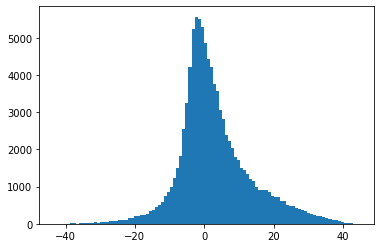

In [ ]:
orthogonal_residual=(saliency_map_raw_AVERAGE[:,:,0]+saliency_map_raw_AVERAGE[:,:,1]+saliency_map_raw_AVERAGE[:,:,2]+saliency_map_raw_AVERAGE[:,:,3]) 
L2 = np.sqrt(np.sum(np.square(saliency_map_raw_AVERAGE[:,:,:]), axis=2))
sine = 1/2 * orthogonal_residual /L2 
sine = np.arcsin(sine) * 180 /( 2* 3.1416) 

sine_average =np.array(sine.reshape(len(sine)*len(sine[0]),))

plt.hist(sine_average, 100)
#plt.hist(sine, 100)

In [ ]:
print(sine.shape)
print(np.average(sine))
print(np.average(np.abs(sine)))
print(np.average(np.std(sine)))

(500, 200)
3.017242
7.6541004
10.441813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(array([2.27820555e-05, 2.27821545e-05, 5.69551388e-05, 5.69551388e-05,
        4.55643090e-05, 1.36692333e-04, 1.36692333e-04, 5.69553863e-05,
        2.05038500e-04, 2.50602611e-04, 1.82257236e-04, 2.61993638e-04,
        2.50603155e-04, 3.98686838e-04, 2.73384666e-04, 4.10077890e-04,
        5.92334730e-04, 6.15116835e-04, 7.63198860e-04, 7.06245255e-04,
        7.85982623e-04, 1.07075661e-03, 1.27579788e-03, 1.23023367e-03,
        1.70865788e-03, 1.83395547e-03, 2.24403734e-03, 2.33516576e-03,
        2.65410947e-03, 2.68828839e-03, 3.13253604e-03, 3.94130417e-03,
        4.23746693e-03, 5.12597363e-03, 5.83221255e-03, 6.81184200e-03,
        8.61163570e-03, 9.69377515e-03, 1.13454883e-02, 1.41590629e-02,
        1.71776979e-02, 2.07317043e-02, 2.89560240e-02, 3.69183811e-02,
        4.79563050e-02, 5.97574290e-02, 6.34822839e-02, 6.28671846e-02,
        6.02244537e-02, 5.53149134e-02, 5.04395463e-02, 4.82182925e-02,
        4.29556357e-02, 4.06204601e-02, 3.47768644e-02, 3.212275

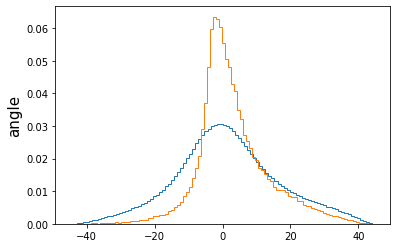

In [ ]:
import matplotlib.pyplot as plt


saliency_map_raw_cummulative=np.array(saliency_map_raw_cummulative)

orthogonal_residual=(saliency_map_raw_cummulative[:,:,:,0]+saliency_map_raw_cummulative[:,:,:,1]+saliency_map_raw_cummulative[:,:,:,2]+saliency_map_raw_cummulative[:,:,:,3]) 
L2 = np.sqrt(np.sum(np.square(saliency_map_raw_cummulative[:,:,:,:]), axis=3))
sine = 1/2 * orthogonal_residual /L2 
sine = np.arcsin(sine) * 180 /( 2* 3.1416) 

sine =np.array(sine.reshape(len(sine)*len(sine[0])*len(sine[0,0]),))
plt.ylabel('density', fontsize=15)
plt.ylabel('angle', fontsize=15)
plt.hist(sine, 100, density=True, histtype='step')
plt.hist(sine_average, 100, density=True, histtype='step')
#plt.yscale('log')

In [ ]:
print(np.average(np.abs(sine_mu)))
print(np.average(np.abs(sine)))

2.5414433
11.16118


In [ ]:
#BETTER

print(np.array(attr_score1_cumulative).shape)

attr_score1_AVERAGE = np.average(np.array(attr_score1_cumulative)  , axis = 0)
attr_score3_AVERAGE = np.average(np.array(attr_score3_cumulative)  , axis = 0)
saliency_map_raw_AVERAGE = np.average(np.array(saliency_map_raw_cummulative)  , axis = 0)

print(attr_score1_AVERAGE.shape)

(50, 500, 200, 4)
(500, 200, 4)


In [ ]:
#print(saliency_map_raw[55][80:90])
#saliency_map_raw = saliency_map_raw - 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True) # np.array(mutagenesis_map)
#saliency_map_raw2 = saliency_map_raw2 - 0.25* np.sum(saliency_map_raw2, axis=2, keepdims=True) # np.array(mutagenesis_map)

saliency_map_raw_AVERAGE_CORRECTED = saliency_map_raw_AVERAGE - 0.25* np.sum(saliency_map_raw_AVERAGE, axis=2, keepdims=True)
saliency_map_raw_CORRECTED = saliency_map_raw - 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True)

#saliency_map_raw = mutagenesis_map
#print(saliency_map_raw[55][80:90])


In [ ]:
'''#Saliency - only saved once??? Commented out for security. 

filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
np.savetxt(filename, np.array(saliency1AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
np.savetxt(filename, np.array(saliency1AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"
np.savetxt(filename, np.array(saliencySCAL_print)[:,0] , delimiter=",") 


filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
np.savetxt(filename, np.array(saliency3AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
np.savetxt(filename, np.array(saliency3AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"
np.savetxt(filename, np.array(saliencySCAL_print)[:,1] , delimiter=",") 



# IG
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
np.savetxt(filename, np.array(integrated1AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
np.savetxt(filename, np.array(integrated1AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"
np.savetxt(filename, np.array(integratedSCAL_print)[:,0] , delimiter=",") 


filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
np.savetxt(filename, np.array(integrated3AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
np.savetxt(filename, np.array(integrated3AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"
np.savetxt(filename, np.array(integratedSCAL_print)[:,1] , delimiter=",") 


In [ ]:
'''num_trials = 50
model_names = ['cnn-exponential'] #['cnn-dist', 'cnn-local']
activations = ['local']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   

#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            predictions = model.predict(x_test)                
            mean_vals, std_vals = calculate_metrics(y_test, predictions, 'binary')
            print(mean_vals, std_vals)

UnboundLocalError: ignored

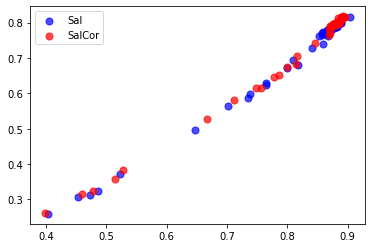

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)


ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency1AUROC_AUPR_print)[:,1], s=50, c='b', marker="o", label='Sal', alpha=0.7)
ax1.scatter(np.array(saliency3AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,1], s=50, c='r', marker="o", label='SalCor', alpha=0.7)
plt.legend(loc='upper left');
plt.show()


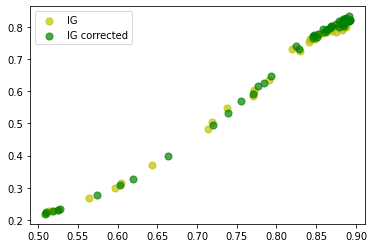

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)


ax1.scatter(np.array(integrated1AUROC_AUPR_print)[:,0], np.array(integrated1AUROC_AUPR_print)[:,1], s=50, c='y', marker="o", label='IG', alpha=0.7)
ax1.scatter(np.array(integrated3AUROC_AUPR_print)[:,0], np.array(integrated3AUROC_AUPR_print)[:,1], s=50, c='g', marker="o", label='IG corrected', alpha=0.7)
plt.legend(loc='upper left');
plt.show()

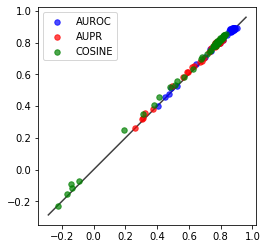

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)
ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
#ax1.set_xlim(0.60,0.92)
#ax1.set_ylim(0.60,0.92)

plt.legend(loc='upper left');
plt.show()

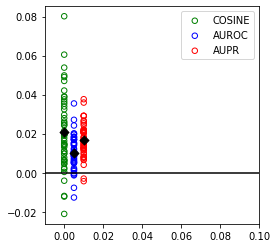

In [ ]:
'''import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#Cosine
ax1.scatter( np.array(saliencySCAL_print)[:,1]*0, np.array(saliencySCAL_print)[:,1]-np.array(saliencySCAL_print)[:,0], s=30, edgecolors='g',facecolors='none', marker="o", label='COSINE')
mean1=np.average(np.array(saliencySCAL_print)[:,1]-np.array(saliencySCAL_print)[:,0])
# AUROC
ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0]*0+0.005, np.array(saliency3AUROC_AUPR_print)[:,0]-np.array(saliency1AUROC_AUPR_print)[:,0], s=30, edgecolors='b', facecolors='none', marker="o", label='AUROC')
mean2=np.average(np.array(saliency3AUROC_AUPR_print)[:,0]-np.array(saliency1AUROC_AUPR_print)[:,0])
#AUPR
ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1]*0+0.01, np.array(saliency3AUROC_AUPR_print)[:,1]-np.array(saliency1AUROC_AUPR_print)[:,1], s=30, edgecolors='r', facecolors='none', marker="o", label='AUPR')
mean3=np.average(np.array(saliency3AUROC_AUPR_print)[:,1]-np.array(saliency1AUROC_AUPR_print)[:,1])

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(-0.01,0.1)
#ax1.set_ylim(0.60,0.92)


#Means and medians
ax1.scatter(0.000, mean1, c="black", marker="D", s=40)
ax1.scatter(0.005, mean2, c="black", marker="D", s=40)
ax1.scatter(0.01, mean3, c="black", marker="D", s=40)
x__ = np.linspace(-0.01, 0.1, 100)
ax1.plot(x__, x__*0, c="black");

plt.legend(loc='upper right');
#plt.xticks(x, " ")
plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


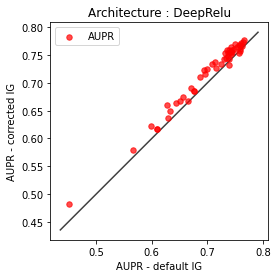

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#####ax1.scatter(np.array(saliency1AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],0], np.array(saliency3AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#####ax1.scatter(np.array(saliency1AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],1], np.array(saliency3AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#ax1.scatter(np.array(integrated1AUROC_AUPR_print)[:,0], np.array(integrated3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)  #ax1.scatter(np.array(saliency1AUROC_AUPR_print)[3:28,0], np.array(saliency3AUROC_AUPR_print)[3:28,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7) 
ax1.scatter(np.array(integrated1AUROC_AUPR_print)[:,1], np.array(integrated3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)
#ax1.scatter(np.array(integratedSCAL_print)[:,0], np.array(integratedSCAL_print)[:,1], s=30, c='g', marker="o", label='Cosine similarity', alpha=0.7)



lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
#ax1.set_xlim(0.5,0.75)
#ax1.set_ylim(0.5,0.75)
plt.xlabel("AUPR - default IG")
plt.ylabel("AUPR - corrected IG")
plt.title("Architecture : DeepRelu")

plt.legend(loc='down right');
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


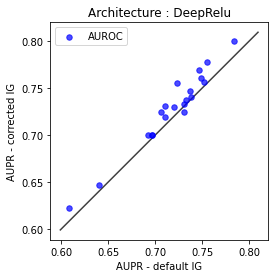

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#####ax1.scatter(np.array(saliency1AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],0], np.array(saliency3AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#####ax1.scatter(np.array(saliency1AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],1], np.array(saliency3AUROC_AUPR_print)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#ax1.scatter(np.array(integrated1AUROC_AUPR_print)[:,0], np.array(integrated3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)  #ax1.scatter(np.array(saliency1AUROC_AUPR_print)[3:28,0], np.array(saliency3AUROC_AUPR_print)[3:28,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7) 
#ax1.scatter(np.array(integrated1AUROC_AUPR_print)[:,1], np.array(integrated3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)
#ax1.scatter(np.array(integratedSCAL_print)[:,0], np.array(integratedSCAL_print)[:,1], s=30, c='g', marker="o", label='Cosine similarity', alpha=0.7)

ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
#ax1.set_xlim(0.54,0.7)
#ax1.set_ylim(0.54,0.7)
plt.xlabel("AUPR - default IG")
plt.ylabel("AUPR - corrected IG")
plt.title("Architecture : DeepRelu")

plt.legend(loc='down right');
plt.show()

In [ ]:
#Saliency and IG load

model_name = 'cnn-dist' #['cnn-dist', 'cnn-local']
activation = 'relu'  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']

filenameSAL_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
filenameSAL_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
filenameSAL_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"

filenameSAL_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
filenameSAL_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
filenameSAL_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"


# IG
filenameIG_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
filenameIG_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
filenameIG_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"

filenameIG_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
filenameIG_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
filenameIG_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"


In [ ]:
[model_name + "_" + activation]

['cnn-local_exponential']

In [ ]:
#Load the interpretability data.
from numpy import loadtxt
#Saliency
'''SAL_AUROC={}
SAL_AUROC_c={}
SAL_AUPR={}
SAL_AUPR_c={}
SAL_COSINE={}
SAL_COSINE_c={}
IG_AUROC={}
IG_AUROC_c={}
IG_AUPR={}
IG_AUPR_c={}
IG_COSINE={}
IG_COSINE_c={}'''

SAL_AUROC[model_name + "_" + activation] = np.array(loadtxt(filenameSAL_AUROC, comments="#", delimiter="\n", unpack=False))
SAL_AUPR[model_name + "_" + activation] = np.array(loadtxt(filenameSAL_AUPR, comments="#", delimiter="\n", unpack=False))
SAL_COSINE[model_name + "_" + activation] = np.array(loadtxt(filenameSAL_COSINE, comments="#", delimiter="\n", unpack=False))

SAL_AUROC_c[model_name + "_" + activation] = np.array(loadtxt(filenameSAL_AUROC_c, comments="#", delimiter="\n", unpack=False))
SAL_AUPR_c[model_name + "_" + activation] = np.array(loadtxt(filenameSAL_AUPR_c, comments="#", delimiter="\n", unpack=False))
SAL_COSINE_c[model_name + "_" + activation] = np.array(loadtxt(filenameSAL_COSINE_c, comments="#", delimiter="\n", unpack=False))

#IG
IG_AUROC[model_name + "_" + activation] = np.array(loadtxt(filenameIG_AUROC, comments="#", delimiter="\n", unpack=False))
IG_AUPR[model_name + "_" + activation] = np.array(loadtxt(filenameIG_AUPR, comments="#", delimiter="\n", unpack=False))
IG_COSINE[model_name + "_" + activation] = np.array(loadtxt(filenameIG_COSINE, comments="#", delimiter="\n", unpack=False))

IG_AUROC_c[model_name + "_" + activation] = np.array(loadtxt(filenameIG_AUROC_c, comments="#", delimiter="\n", unpack=False))
IG_AUPR_c[model_name + "_" + activation] = np.array(loadtxt(filenameIG_AUPR_c, comments="#", delimiter="\n", unpack=False))
IG_COSINE_c[model_name + "_" + activation] = np.array(loadtxt(filenameIG_COSINE_c, comments="#", delimiter="\n", unpack=False))


No handles with labels found to put in legend.


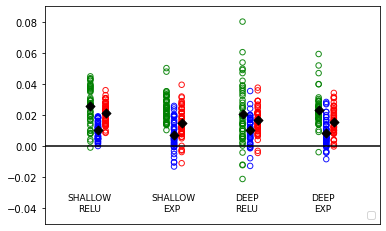

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

alpha=0.9
#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_relu']*0+0, SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'])
# AUROC
ax1.scatter(SAL_AUROC['cnn-local_relu']*0+0.005, SAL_AUROC_c['cnn-local_relu']-SAL_AUROC['cnn-local_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha) #label='AUROC'
mean2a=np.average(SAL_AUROC_c['cnn-local_relu']-SAL_AUROC['cnn-local_relu'])
#AUPR
ax1.scatter(SAL_AUPR['cnn-local_relu']*0+0.01, SAL_AUPR_c['cnn-local_relu']-SAL_AUPR['cnn-local_relu'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha) #
mean3a=np.average(SAL_AUPR_c['cnn-local_relu']-SAL_AUPR['cnn-local_relu'])
#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_exponential']*0+0.05, SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'])
# AUROC
ax1.scatter(SAL_AUROC['cnn-local_exponential']*0+0.055, SAL_AUROC_c['cnn-local_exponential']-SAL_AUROC['cnn-local_exponential'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2b=np.average(SAL_AUROC_c['cnn-local_exponential']-SAL_AUROC['cnn-local_exponential'])
#AUPR
ax1.scatter(SAL_AUPR['cnn-local_exponential']*0+0.06, SAL_AUPR_c['cnn-local_exponential']-SAL_AUPR['cnn-local_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean3b=np.average(SAL_AUPR_c['cnn-local_exponential']-SAL_AUPR['cnn-local_exponential'])
#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_relu']*0+0.10, SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu']))
# AUROC
ax1.scatter(SAL_AUROC['cnn-dist_relu']*0+0.105, SAL_AUROC_c['cnn-dist_relu']-SAL_AUROC['cnn-dist_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2c=np.average(SAL_AUROC_c['cnn-dist_relu']-SAL_AUROC['cnn-dist_relu'])
#AUPR
ax1.scatter(SAL_AUPR['cnn-dist_relu']*0+0.11, SAL_AUPR_c['cnn-dist_relu']-SAL_AUPR['cnn-dist_relu'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean3c=np.average(np.nan_to_num(SAL_AUPR_c['cnn-dist_relu']-SAL_AUPR['cnn-dist_relu']))
#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_exponential']*0+0.15, SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential']))
# AUROC
ax1.scatter(SAL_AUROC['cnn-dist_exponential']*0+0.155, SAL_AUROC_c['cnn-dist_exponential']-SAL_AUROC['cnn-dist_exponential'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2d=np.average(SAL_AUROC_c['cnn-dist_exponential']-SAL_AUROC['cnn-dist_exponential'])
#AUPR
ax1.scatter(SAL_AUPR['cnn-dist_exponential']*0+0.16, SAL_AUPR_c['cnn-dist_exponential']-SAL_AUPR['cnn-dist_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean3d=np.average(np.nan_to_num(SAL_AUPR_c['cnn-dist_exponential']-SAL_AUPR['cnn-dist_exponential']))

#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
ax1.set_xlim(-0.03,0.19)
ax1.set_ylim(-0.05,0.09)


#Means and medians
ax1.scatter(0.000, mean1a, c="black", marker="D", s=40)
ax1.scatter(0.005, mean2a, c="black", marker="D", s=40)
ax1.scatter(0.01, mean3a, c="black", marker="D", s=40)
#-------
ax1.scatter(0.05, mean1b, c="black", marker="D", s=40)
ax1.scatter(0.055, mean2b, c="black", marker="D", s=40)
ax1.scatter(0.06, mean3b, c="black", marker="D", s=40)
x__ = np.linspace(-0.01, 0.1, 100)
#-------
ax1.scatter(0.10, mean1c, c="black", marker="D", s=40)
ax1.scatter(0.105, mean2c, c="black", marker="D", s=40)
ax1.scatter(0.11, mean3c, c="black", marker="D", s=40)
#-------
ax1.scatter(0.15, mean1d, c="black", marker="D", s=40)
ax1.scatter(0.155, mean2d, c="black", marker="D", s=40)
ax1.scatter(0.16, mean3d, c="black", marker="D", s=40)

x__ = np.linspace(-0.03, 0.19, 100)
ax1.plot(x__, x__*0, c="black");

ax1.text(-0.015, -0.035, 'SHALLOW', fontsize=9)
ax1.text(-0.008, -0.042, 'RELU', fontsize=9)
ax1.text(0.04, -0.035, 'SHALLOW', fontsize=9)
ax1.text(0.048, -0.042, 'EXP', fontsize=9)
ax1.text(0.095, -0.035, 'DEEP', fontsize=9)
ax1.text(0.095, -0.042, 'RELU', fontsize=9)
ax1.text(0.145, -0.035, 'DEEP', fontsize=9)
ax1.text(0.147, -0.042, 'EXP', fontsize=9)

plt.legend(loc='lower right');
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.savefig('drive/My Drive/results/three_colors_saliency.pdf')  
plt.show()



In [ ]:
print(np.average(SAL_COSINE['cnn-local_relu']))
print(np.average(SAL_COSINE_c['cnn-local_relu']))

0.5528330856561661
0.5786380732059478


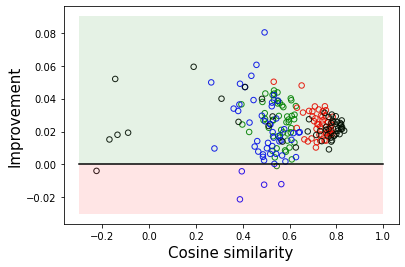

In [ ]:
# Saliency Cosine
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (-0.3, 0), 1.3, 0.09, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (-0.3, 0), 1.3, -0.03, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_relu'], SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_exponential'], SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_relu'], SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu']))

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_exponential'], SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential']))


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(-0.3, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Cosine similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/Cosine_Saliency.pdf')  
plt.show()


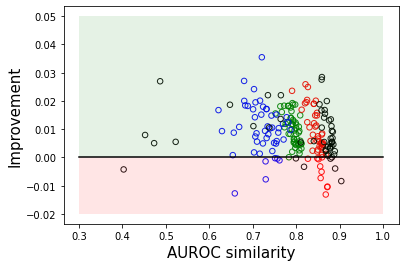

In [ ]:
#AUROC Saliency 
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (0.3, 0), 0.7, 0.05, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (0.3, 0), 0.7, -0.02, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter(SAL_AUROC['cnn-local_relu'], SAL_AUROC_c['cnn-local_relu']-SAL_AUROC['cnn-local_relu'], s=30, edgecolors='g', facecolors='none', marker="o", alpha=alpha) #label='AUROC'
mean2a=np.average(SAL_AUROC_c['cnn-local_relu']-SAL_AUROC['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter(SAL_AUROC['cnn-local_exponential'], SAL_AUROC_c['cnn-local_exponential']-SAL_AUROC['cnn-local_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean2b=np.average(SAL_AUROC_c['cnn-local_exponential']-SAL_AUROC['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter(SAL_AUROC['cnn-dist_relu'], SAL_AUROC_c['cnn-dist_relu']-SAL_AUROC['cnn-dist_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2c=np.average(SAL_AUROC_c['cnn-dist_relu']-SAL_AUROC['cnn-dist_relu'])

#---------------------
#Cosine
ax1.scatter(SAL_AUROC['cnn-dist_exponential'], SAL_AUROC_c['cnn-dist_exponential']-SAL_AUROC['cnn-dist_exponential'], s=30, edgecolors='black', facecolors='none', marker="o", alpha=alpha)
mean2d=np.average(SAL_AUROC_c['cnn-dist_exponential']-SAL_AUROC['cnn-dist_exponential'])


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.3, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('AUROC similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/AUROC_Saliency.pdf')  
plt.show()

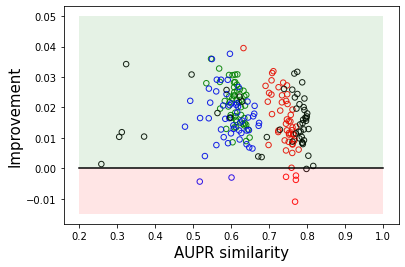

In [ ]:
#AUPR Saliency 
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUPR_AUPR_print)[:,0], np.array(saliency3AUPR_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUPR', alpha=0.7)
#ax1.scatter(np.array(saliency1AUPR_AUPR_print)[:,1], np.array(saliency3AUPR_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (0.2, 0), 0.8, 0.05, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (0.2, 0), 0.8, -0.015, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter(SAL_AUPR['cnn-local_relu'], SAL_AUPR_c['cnn-local_relu']-SAL_AUPR['cnn-local_relu'], s=30, edgecolors='g', facecolors='none', marker="o", alpha=alpha) #label='AUPR'
mean2a=np.average(SAL_AUPR_c['cnn-local_relu']-SAL_AUPR['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter(SAL_AUPR['cnn-local_exponential'], SAL_AUPR_c['cnn-local_exponential']-SAL_AUPR['cnn-local_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean2b=np.average(SAL_AUPR_c['cnn-local_exponential']-SAL_AUPR['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter(SAL_AUPR['cnn-dist_relu'], SAL_AUPR_c['cnn-dist_relu']-SAL_AUPR['cnn-dist_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2c=np.average(SAL_AUPR_c['cnn-dist_relu']-SAL_AUPR['cnn-dist_relu'])

#---------------------
#Cosine
ax1.scatter(SAL_AUPR['cnn-dist_exponential'], SAL_AUPR_c['cnn-dist_exponential']-SAL_AUPR['cnn-dist_exponential'], s=30, edgecolors='black', facecolors='none', marker="o", alpha=alpha)
mean2d=np.average(SAL_AUPR_c['cnn-dist_exponential']-SAL_AUPR['cnn-dist_exponential'])


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.2, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('AUPR similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/AUPR_Saliency.pdf')  
plt.show()

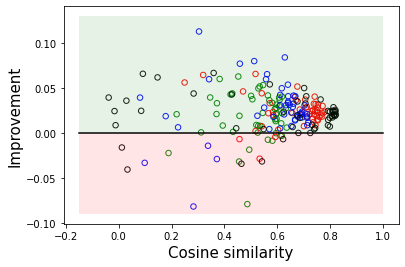

In [ ]:
# IG Cosine 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(IGiencySCAL_print)[:,0], np.array(IGiencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUROC_AUPR_print)[:,0], np.array(IGiency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUROC_AUPR_print)[:,1], np.array(IGiency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (-0.15, 0), 1.15, 0.13, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (-0.15, 0), 1.15, -0.09, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-local_relu'], IG_COSINE_c['cnn-local_relu']-IG_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(IG_COSINE_c['cnn-local_relu']-IG_COSINE['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-local_exponential'], IG_COSINE_c['cnn-local_exponential']-IG_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(IG_COSINE_c['cnn-local_exponential']-IG_COSINE['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-dist_relu'], IG_COSINE_c['cnn-dist_relu']-IG_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(IG_COSINE_c['cnn-dist_relu']-IG_COSINE['cnn-dist_relu']))

#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-dist_exponential'], IG_COSINE_c['cnn-dist_exponential']-IG_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(IG_COSINE_c['cnn-dist_exponential']-IG_COSINE['cnn-dist_exponential']))


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(-0.15, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Cosine similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/Cosine_IG.pdf')  
plt.show()

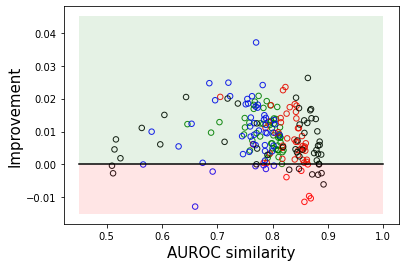

In [ ]:
#AUROC IG
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(IGiencySCAL_print)[:,0], np.array(IGiencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUROC_AUPR_print)[:,0], np.array(IGiency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUROC_AUPR_print)[:,1], np.array(IGiency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (0.45, 0), 0.55, 0.045, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (0.45, 0), 0.55, -0.015, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter(IG_AUROC['cnn-local_relu'], IG_AUROC_c['cnn-local_relu']-IG_AUROC['cnn-local_relu'], s=30, edgecolors='g', facecolors='none', marker="o", alpha=alpha) #label='AUROC'
mean2a=np.average(IG_AUROC_c['cnn-local_relu']-IG_AUROC['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter(IG_AUROC['cnn-local_exponential'], IG_AUROC_c['cnn-local_exponential']-IG_AUROC['cnn-local_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean2b=np.average(IG_AUROC_c['cnn-local_exponential']-IG_AUROC['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter(IG_AUROC['cnn-dist_relu'], IG_AUROC_c['cnn-dist_relu']-IG_AUROC['cnn-dist_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2c=np.average(IG_AUROC_c['cnn-dist_relu']-IG_AUROC['cnn-dist_relu'])

#---------------------
#Cosine
ax1.scatter(IG_AUROC['cnn-dist_exponential'], IG_AUROC_c['cnn-dist_exponential']-IG_AUROC['cnn-dist_exponential'], s=30, edgecolors='black', facecolors='none', marker="o", alpha=alpha)
mean2d=np.average(IG_AUROC_c['cnn-dist_exponential']-IG_AUROC['cnn-dist_exponential'])


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.45, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('AUROC similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/AUROC_IG.pdf')  
plt.show()

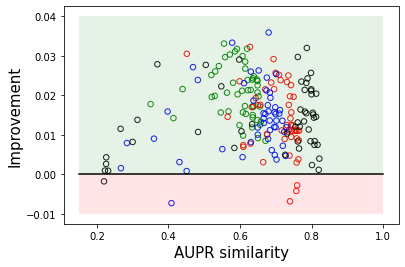

In [ ]:
#AUPR IG
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(IGiencySCAL_print)[:,0], np.array(IGiencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUPR_AUPR_print)[:,0], np.array(IGiency3AUPR_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUPR', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUPR_AUPR_print)[:,1], np.array(IGiency3AUPR_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (0.15, 0), 0.85, 0.04, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (0.15, 0), 0.85, -0.01, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter(IG_AUPR['cnn-local_relu'], IG_AUPR_c['cnn-local_relu']-IG_AUPR['cnn-local_relu'], s=30, edgecolors='g', facecolors='none', marker="o", alpha=alpha) #label='AUPR'
mean2a=np.average(IG_AUPR_c['cnn-local_relu']-IG_AUPR['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter(IG_AUPR['cnn-local_exponential'], IG_AUPR_c['cnn-local_exponential']-IG_AUPR['cnn-local_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean2b=np.average(IG_AUPR_c['cnn-local_exponential']-IG_AUPR['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter(IG_AUPR['cnn-dist_relu'], IG_AUPR_c['cnn-dist_relu']-IG_AUPR['cnn-dist_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2c=np.average(IG_AUPR_c['cnn-dist_relu']-IG_AUPR['cnn-dist_relu'])

#---------------------
#Cosine
ax1.scatter(IG_AUPR['cnn-dist_exponential'], IG_AUPR_c['cnn-dist_exponential']-IG_AUPR['cnn-dist_exponential'], s=30, edgecolors='black', facecolors='none', marker="o", alpha=alpha)
mean2d=np.average(IG_AUPR_c['cnn-dist_exponential']-IG_AUPR['cnn-dist_exponential'])


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.15, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('AUPR similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/AUPR_IG.pdf')  
plt.show()

No handles with labels found to put in legend.


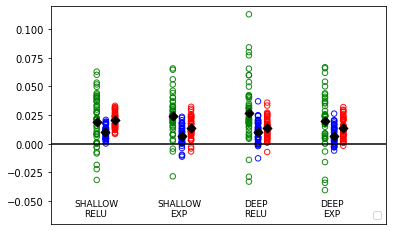

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(IGiencySCAL_print)[:,0], np.array(IGiencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUROC_AUPR_print)[:,0], np.array(IGiency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(IGiency1AUROC_AUPR_print)[:,1], np.array(IGiency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

alpha=0.9
#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-local_relu']*0+0, IG_COSINE_c['cnn-local_relu']-IG_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(IG_COSINE_c['cnn-local_relu']-IG_COSINE['cnn-local_relu'])
# AUROC
ax1.scatter(IG_AUROC['cnn-local_relu']*0+0.006, IG_AUROC_c['cnn-local_relu']-IG_AUROC['cnn-local_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha) #label='AUROC'
mean2a=np.average(IG_AUROC_c['cnn-local_relu']-IG_AUROC['cnn-local_relu'])
#AUPR
ax1.scatter(IG_AUPR['cnn-local_relu']*0+0.012, IG_AUPR_c['cnn-local_relu']-IG_AUPR['cnn-local_relu'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha) #
mean3a=np.average(IG_AUPR_c['cnn-local_relu']-IG_AUPR['cnn-local_relu'])
#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-local_exponential']*0+0.05, IG_COSINE_c['cnn-local_exponential']-IG_COSINE['cnn-local_exponential'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(IG_COSINE_c['cnn-local_exponential']-IG_COSINE['cnn-local_exponential'])
# AUROC
ax1.scatter(IG_AUROC['cnn-local_exponential']*0+0.056, IG_AUROC_c['cnn-local_exponential']-IG_AUROC['cnn-local_exponential'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2b=np.average(IG_AUROC_c['cnn-local_exponential']-IG_AUROC['cnn-local_exponential'])
#AUPR
ax1.scatter(IG_AUPR['cnn-local_exponential']*0+0.062, IG_AUPR_c['cnn-local_exponential']-IG_AUPR['cnn-local_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean3b=np.average(IG_AUPR_c['cnn-local_exponential']-IG_AUPR['cnn-local_exponential'])
#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-dist_relu']*0+0.10, IG_COSINE_c['cnn-dist_relu']-IG_COSINE['cnn-dist_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(IG_COSINE_c['cnn-dist_relu']-IG_COSINE['cnn-dist_relu']))
# AUROC
ax1.scatter(IG_AUROC['cnn-dist_relu']*0+0.106, IG_AUROC_c['cnn-dist_relu']-IG_AUROC['cnn-dist_relu'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2c=np.average(IG_AUROC_c['cnn-dist_relu']-IG_AUROC['cnn-dist_relu'])
#AUPR
ax1.scatter(IG_AUPR['cnn-dist_relu']*0+0.112, IG_AUPR_c['cnn-dist_relu']-IG_AUPR['cnn-dist_relu'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean3c=np.average(np.nan_to_num(IG_AUPR_c['cnn-dist_relu']-IG_AUPR['cnn-dist_relu']))
#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-dist_exponential']*0+0.15, IG_COSINE_c['cnn-dist_exponential']-IG_COSINE['cnn-dist_exponential'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(IG_COSINE_c['cnn-dist_exponential']-IG_COSINE['cnn-dist_exponential']))
# AUROC
ax1.scatter(IG_AUROC['cnn-dist_exponential']*0+0.156, IG_AUROC_c['cnn-dist_exponential']-IG_AUROC['cnn-dist_exponential'], s=30, edgecolors='b', facecolors='none', marker="o", alpha=alpha)
mean2d=np.average(IG_AUROC_c['cnn-dist_exponential']-IG_AUROC['cnn-dist_exponential'])
#AUPR
ax1.scatter(IG_AUPR['cnn-dist_exponential']*0+0.162, IG_AUPR_c['cnn-dist_exponential']-IG_AUPR['cnn-dist_exponential'], s=30, edgecolors='r', facecolors='none', marker="o", alpha=alpha)
mean3d=np.average(np.nan_to_num(IG_AUPR_c['cnn-dist_exponential']-IG_AUPR['cnn-dist_exponential']))

#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
ax1.set_xlim(-0.03,0.19)
ax1.set_ylim(-0.07,0.12)


#Means and medians
ax1.scatter(0.000, mean1a, c="black", marker="D", s=40)
ax1.scatter(0.0056, mean2a, c="black", marker="D", s=40)
ax1.scatter(0.012, mean3a, c="black", marker="D", s=40)
#-------
ax1.scatter(0.05, mean1b, c="black", marker="D", s=40)
ax1.scatter(0.056, mean2b, c="black", marker="D", s=40)
ax1.scatter(0.062, mean3b, c="black", marker="D", s=40)
x__ = np.linspace(-0.01, 0.1, 100)
#-------
ax1.scatter(0.10, mean1c, c="black", marker="D", s=40)
ax1.scatter(0.106, mean2c, c="black", marker="D", s=40)
ax1.scatter(0.112, mean3c, c="black", marker="D", s=40)
#-------
ax1.scatter(0.15, mean1d, c="black", marker="D", s=40)
ax1.scatter(0.156, mean2d, c="black", marker="D", s=40)
ax1.scatter(0.162, mean3d, c="black", marker="D", s=40)

x__ = np.linspace(-0.03, 0.19, 100)
ax1.plot(x__, x__*0, c="black");

ax1.text(-0.015, -0.055, 'SHALLOW', fontsize=9)
ax1.text(-0.008, -0.063, 'RELU', fontsize=9)
ax1.text(0.04, -0.055, 'SHALLOW', fontsize=9)
ax1.text(0.048, -0.063, 'EXP', fontsize=9)
ax1.text(0.097, -0.055, 'DEEP', fontsize=9)
ax1.text(0.097, -0.063, 'RELU', fontsize=9)
ax1.text(0.147, -0.055, 'DEEP', fontsize=9)
ax1.text(0.149, -0.063, 'EXP', fontsize=9)

plt.legend(loc='lower right');
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.savefig('drive/My Drive/results/three_colors_IG.pdf')  

plt.show()


In [ ]:
figure_title = "     Shallow-ReLU               Shallow-Exponetial"

all_scores = []
all_scores.append(SAL_AUROC)
all_scores.append(SAL_AUROC_c)
all_scores.append(SAL_AUPR)
all_scores.append(SAL_AUPR_c)
all_scores.append(SAL_COSINE)
all_scores.append(SAL_COSINE_c)
all_scores = np.array(all_scores)    

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4], [ 'Saliency', 'Saliency corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('AUROC', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'green' )
    # change hatch
    #box.set(hatch = '.')



plt.show()

NameError: ignored

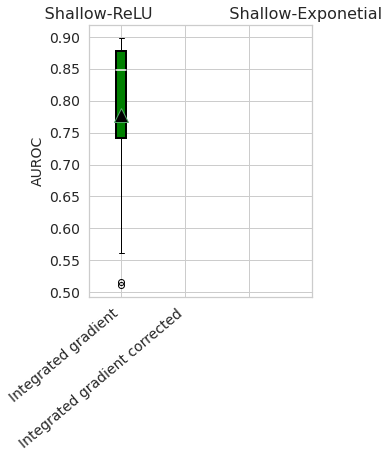

In [ ]:
figure_title = "     Shallow-ReLU               Shallow-Exponetial"

all_scores = []
#all_scores.append(IG_AUROC)
#all_scores.append(IG_AUROC_c)
#all_scores.append(IG_AUPR)
#all_scores.append(IG_AUPR_c)
#all_scores.append(IG_COSINE)
#all_scores.append(IG_COSINE_c)
all_scores = np.array(all_scores)    

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4], [ 'Integrated gradient', 'Integrated gradient corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('AUROC', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'green' )
    # change hatch
    #box.set(hatch = '.')



plt.show()

In [ ]:
#################################################### ALL TOGETHER - COSINE

all_scores = []
model_name = 'cnn-local'
activation = 'exponential'
filenameSAL_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"
filenameSAL_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"
SAL_COSINE = np.array(loadtxt(filenameSAL_COSINE, comments="#", delimiter="\n", unpack=False))
SAL_COSINE = SAL_COSINE[~np.isnan(SAL_COSINE)]
SAL_COSINE_c = np.array(loadtxt(filenameSAL_COSINE_c, comments="#", delimiter="\n", unpack=False))
SAL_COSINE_c = SAL_COSINE_c[~np.isnan(SAL_COSINE_c)]
all_scores.append(SAL_COSINE)
all_scores.append(SAL_COSINE_c)
all_scores.append(np.array([]))

model_name = 'cnn-local'
activation = 'relu'
filenameSAL_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"
filenameSAL_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"
SAL_COSINE = np.array(loadtxt(filenameSAL_COSINE, comments="#", delimiter="\n", unpack=False))
SAL_COSINE_c = np.array(loadtxt(filenameSAL_COSINE_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_COSINE)
all_scores.append(SAL_COSINE_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'exponential'
filenameSAL_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"
filenameSAL_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"
SAL_COSINE = np.array(loadtxt(filenameSAL_COSINE, comments="#", delimiter="\n", unpack=False))
SAL_COSINE_c = np.array(loadtxt(filenameSAL_COSINE_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_COSINE)
all_scores.append(SAL_COSINE_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'relu'
filenameSAL_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"
filenameSAL_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"
SAL_COSINE = np.array(loadtxt(filenameSAL_COSINE, comments="#", delimiter="\n", unpack=False))
SAL_COSINE_c = np.array(loadtxt(filenameSAL_COSINE_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_COSINE)
all_scores.append(SAL_COSINE_c)

all_scores = np.array(all_scores)    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


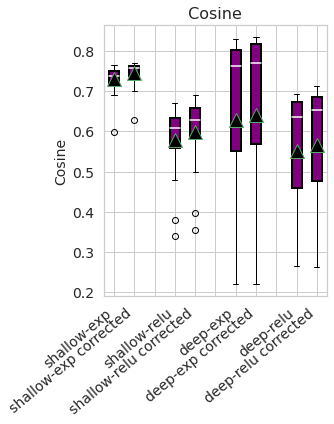

In [ ]:
########################## ALL TOGETHER COSINE PLOT

figure_title = " Cosine "

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [ 'shallow-exp', 'shallow-exp corrected', '', 'shallow-relu', 'shallow-relu corrected', '', 'deep-exp', 'deep-exp corrected', '', 'deep-relu', 'deep-relu corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('Cosine', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'purple' )
    # change hatch
    #box.set(hatch = '.')

plt.show()


In [ ]:
#################################################### ALL TOGETHER - AUROC

all_scores = []
model_name = 'cnn-local'
activation = 'exponential'
filenameSAL_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
filenameSAL_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
SAL_AUROC = np.array(loadtxt(filenameSAL_AUROC, comments="#", delimiter="\n", unpack=False))
SAL_AUROC = SAL_AUROC[~np.isnan(SAL_AUROC)]
SAL_AUROC_c = np.array(loadtxt(filenameSAL_AUROC_c, comments="#", delimiter="\n", unpack=False))
SAL_AUROC_c = SAL_AUROC_c[~np.isnan(SAL_AUROC_c)]
all_scores.append(SAL_AUROC)
all_scores.append(SAL_AUROC_c)
all_scores.append(np.array([]))

model_name = 'cnn-local'
activation = 'relu'
filenameSAL_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
filenameSAL_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
SAL_AUROC = np.array(loadtxt(filenameSAL_AUROC, comments="#", delimiter="\n", unpack=False))
SAL_AUROC_c = np.array(loadtxt(filenameSAL_AUROC_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_AUROC)
all_scores.append(SAL_AUROC_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'exponential'
filenameSAL_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
filenameSAL_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
SAL_AUROC = np.array(loadtxt(filenameSAL_AUROC, comments="#", delimiter="\n", unpack=False))
SAL_AUROC_c = np.array(loadtxt(filenameSAL_AUROC_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_AUROC)
all_scores.append(SAL_AUROC_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'relu'
filenameSAL_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
filenameSAL_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
SAL_AUROC = np.array(loadtxt(filenameSAL_AUROC, comments="#", delimiter="\n", unpack=False))
SAL_AUROC_c = np.array(loadtxt(filenameSAL_AUROC_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_AUROC)
all_scores.append(SAL_AUROC_c)

all_scores = np.array(all_scores) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


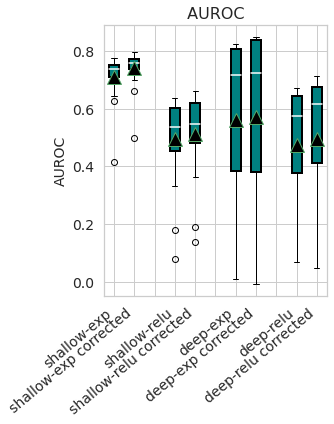

In [ ]:
########################## ALL TOGETHER COSINE PLOT

figure_title = " AUROC "

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [ 'shallow-exp', 'shallow-exp corrected', '', 'shallow-relu', 'shallow-relu corrected', '', 'deep-exp', 'deep-exp corrected', '', 'deep-relu', 'deep-relu corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('AUROC', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'teal' )
    # change hatch
    #box.set(hatch = '.')



plt.show()

In [ ]:
#################################################### ALL TOGETHER - AUPR

all_scores = []
model_name = 'cnn-local'
activation = 'exponential'
filenameSAL_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
filenameSAL_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
SAL_AUPR = np.array(loadtxt(filenameSAL_AUPR, comments="#", delimiter="\n", unpack=False))
SAL_AUPR = SAL_AUPR[~np.isnan(SAL_AUPR)]
SAL_AUPR_c = np.array(loadtxt(filenameSAL_AUPR_c, comments="#", delimiter="\n", unpack=False))
SAL_AUPR_c = SAL_AUPR_c[~np.isnan(SAL_AUPR_c)]
all_scores.append(SAL_AUPR)
all_scores.append(SAL_AUPR_c)
all_scores.append(np.array([]))

model_name = 'cnn-local'
activation = 'relu'
filenameSAL_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
filenameSAL_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
SAL_AUPR = np.array(loadtxt(filenameSAL_AUPR, comments="#", delimiter="\n", unpack=False))
SAL_AUPR_c = np.array(loadtxt(filenameSAL_AUPR_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_AUPR)
all_scores.append(SAL_AUPR_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'exponential'
filenameSAL_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
filenameSAL_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
SAL_AUPR = np.array(loadtxt(filenameSAL_AUPR, comments="#", delimiter="\n", unpack=False))
SAL_AUPR_c = np.array(loadtxt(filenameSAL_AUPR_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_AUPR)
all_scores.append(SAL_AUPR_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'relu'
filenameSAL_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
filenameSAL_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
SAL_AUPR = np.array(loadtxt(filenameSAL_AUPR, comments="#", delimiter="\n", unpack=False))
SAL_AUPR_c = np.array(loadtxt(filenameSAL_AUPR_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(SAL_AUPR)
all_scores.append(SAL_AUPR_c)

all_scores = np.array(all_scores) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


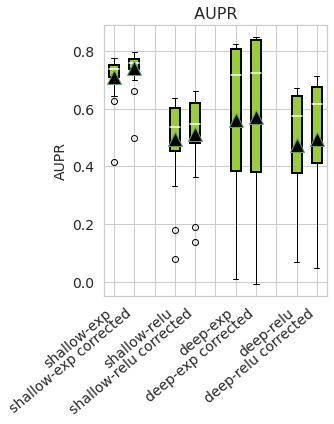

In [ ]:
########################## ALL TOGETHER COSINE PLOT

figure_title = " AUPR "

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [ 'shallow-exp', 'shallow-exp corrected', '', 'shallow-relu', 'shallow-relu corrected', '', 'deep-exp', 'deep-exp corrected', '', 'deep-relu', 'deep-relu corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('AUPR', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'yellowgreen' )
    # change hatch
    #box.set(hatch = '.')



plt.show()

INTEGRATED GRADIENTS PLOTS

In [ ]:
#################################################### ALL TOGETHER - COSINE

all_scores = []
model_name = 'cnn-local'
activation = 'exponential'
filenameIG_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"
filenameIG_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"
IG_COSINE = np.array(loadtxt(filenameIG_COSINE, comments="#", delimiter="\n", unpack=False))
IG_COSINE = IG_COSINE[~np.isnan(IG_COSINE)]
IG_COSINE_c = np.array(loadtxt(filenameIG_COSINE_c, comments="#", delimiter="\n", unpack=False))
IG_COSINE_c = IG_COSINE_c[~np.isnan(IG_COSINE_c)]
all_scores.append(IG_COSINE)
all_scores.append(IG_COSINE_c)
all_scores.append(np.array([]))

model_name = 'cnn-local'
activation = 'relu'
filenameIG_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"
filenameIG_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"
IG_COSINE = np.array(loadtxt(filenameIG_COSINE, comments="#", delimiter="\n", unpack=False))
IG_COSINE_c = np.array(loadtxt(filenameIG_COSINE_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_COSINE)
all_scores.append(IG_COSINE_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'exponential'
filenameIG_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"
filenameIG_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"
IG_COSINE = np.array(loadtxt(filenameIG_COSINE, comments="#", delimiter="\n", unpack=False))
IG_COSINE_c = np.array(loadtxt(filenameIG_COSINE_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_COSINE)
all_scores.append(IG_COSINE_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'relu'
filenameIG_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"
filenameIG_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"
IG_COSINE = np.array(loadtxt(filenameIG_COSINE, comments="#", delimiter="\n", unpack=False))
IG_COSINE_c = np.array(loadtxt(filenameIG_COSINE_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_COSINE)
all_scores.append(IG_COSINE_c)

all_scores = np.array(all_scores)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


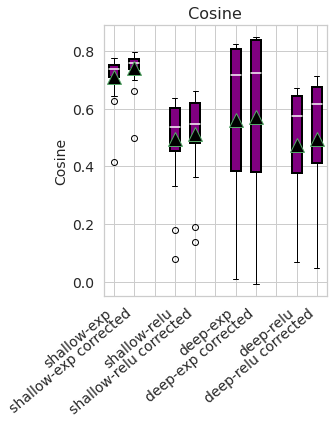

In [ ]:
########################## ALL TOGETHER COSINE PLOT

figure_title = " Cosine "

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [ 'shallow-exp', 'shallow-exp corrected', '', 'shallow-relu', 'shallow-relu corrected', '', 'deep-exp', 'deep-exp corrected', '', 'deep-relu', 'deep-relu corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('Cosine', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'purple' )
    # change hatch
    #box.set(hatch = '.')



plt.show()

In [ ]:
#################################################### ALL TOGETHER - AUROC

all_scores = []
model_name = 'cnn-local'
activation = 'exponential'
filenameIG_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
filenameIG_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
IG_AUROC = np.array(loadtxt(filenameIG_AUROC, comments="#", delimiter="\n", unpack=False))
IG_AUROC = IG_AUROC[~np.isnan(IG_AUROC)]
IG_AUROC_c = np.array(loadtxt(filenameIG_AUROC_c, comments="#", delimiter="\n", unpack=False))
IG_AUROC_c = IG_AUROC_c[~np.isnan(IG_AUROC_c)]
all_scores.append(IG_AUROC)
all_scores.append(IG_AUROC_c)
all_scores.append(np.array([]))

model_name = 'cnn-local'
activation = 'relu'
filenameIG_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
filenameIG_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
IG_AUROC = np.array(loadtxt(filenameIG_AUROC, comments="#", delimiter="\n", unpack=False))
IG_AUROC_c = np.array(loadtxt(filenameIG_AUROC_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_AUROC)
all_scores.append(IG_AUROC_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'exponential'
filenameIG_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
filenameIG_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
IG_AUROC = np.array(loadtxt(filenameIG_AUROC, comments="#", delimiter="\n", unpack=False))
IG_AUROC_c = np.array(loadtxt(filenameIG_AUROC_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_AUROC)
all_scores.append(IG_AUROC_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'relu'
filenameIG_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
filenameIG_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
IG_AUROC = np.array(loadtxt(filenameIG_AUROC, comments="#", delimiter="\n", unpack=False))
IG_AUROC_c = np.array(loadtxt(filenameIG_AUROC_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_AUROC)
all_scores.append(IG_AUROC_c)

all_scores = np.array(all_scores)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


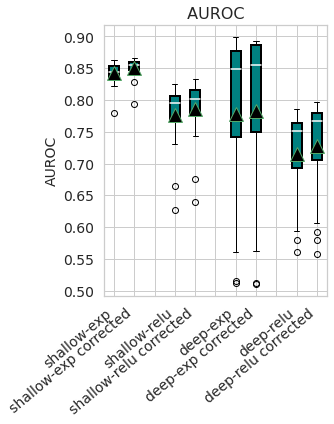

In [ ]:
########################## ALL TOGETHER COSINE PLOT

figure_title = " AUROC "

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [ 'shallow-exp', 'shallow-exp corrected', '', 'shallow-relu', 'shallow-relu corrected', '', 'deep-exp', 'deep-exp corrected', '', 'deep-relu', 'deep-relu corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('AUROC', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'teal' )
    # change hatch
    #box.set(hatch = '.')



plt.show()

In [ ]:
#################################################### ALL TOGETHER - AUPR

all_scores = []
model_name = 'cnn-local'
activation = 'exponential'
filenameIG_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
filenameIG_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
IG_AUPR = np.array(loadtxt(filenameIG_AUPR, comments="#", delimiter="\n", unpack=False))
IG_AUPR = IG_AUPR[~np.isnan(IG_AUPR)]
IG_AUPR_c = np.array(loadtxt(filenameIG_AUPR_c, comments="#", delimiter="\n", unpack=False))
IG_AUPR_c = IG_AUPR_c[~np.isnan(IG_AUPR_c)]
all_scores.append(IG_AUPR)
all_scores.append(IG_AUPR_c)
all_scores.append(np.array([]))

model_name = 'cnn-local'
activation = 'relu'
filenameIG_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
filenameIG_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
IG_AUPR = np.array(loadtxt(filenameIG_AUPR, comments="#", delimiter="\n", unpack=False))
IG_AUPR_c = np.array(loadtxt(filenameIG_AUPR_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_AUPR)
all_scores.append(IG_AUPR_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'exponential'
filenameIG_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
filenameIG_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
IG_AUPR = np.array(loadtxt(filenameIG_AUPR, comments="#", delimiter="\n", unpack=False))
IG_AUPR_c = np.array(loadtxt(filenameIG_AUPR_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_AUPR)
all_scores.append(IG_AUPR_c)
all_scores.append(np.array([]))

model_name = 'cnn-dist'
activation = 'relu'
filenameIG_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
filenameIG_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
IG_AUPR = np.array(loadtxt(filenameIG_AUPR, comments="#", delimiter="\n", unpack=False))
IG_AUPR_c = np.array(loadtxt(filenameIG_AUPR_c, comments="#", delimiter="\n", unpack=False))
all_scores.append(IG_AUPR)
all_scores.append(IG_AUPR_c)

all_scores = np.array(all_scores)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


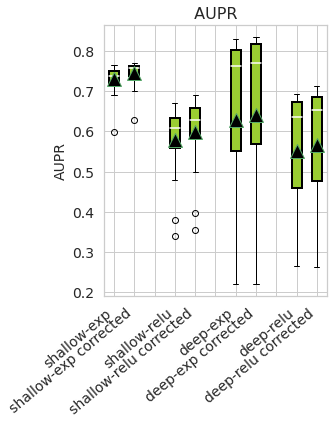

In [ ]:
########################## ALL TOGETHER COSINE PLOT

figure_title = " AUPR "

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='black', markersize=14, linestyle='none')  
medianprops = dict(color="white",linewidth=1.5)
box = plt.boxplot(all_scores.T, showfliers=True, showmeans=True, meanprops=flierprops, patch_artist=True, medianprops=medianprops);
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [ 'shallow-exp', 'shallow-exp corrected', '', 'shallow-relu', 'shallow-relu corrected', '', 'deep-exp', 'deep-exp corrected', '', 'deep-relu', 'deep-relu corrected'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
#ax.set_ylim(-3,6) #ANTONIO
ax.set_title(figure_title, fontsize=16) #ANTONIO
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('AUPR', fontsize=14)

for box in box['boxes']:
    # change outline color
    box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'yellowgreen' )
    # change hatch
    #box.set(hatch = '.')



plt.show()

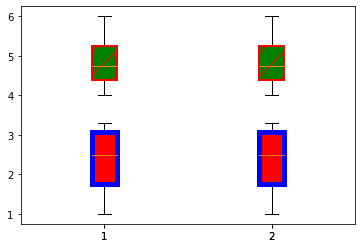

In [ ]:
import matplotlib.pyplot as plt

# fake data
d0 = [[4.5, 5, 6, 4],[4.5, 5, 6, 4]]
d1 = [[1, 2, 3, 3.3],[1, 2, 3, 3.3]]

# basic plot
bp0 = plt.boxplot(d0, patch_artist=True)
bp1 = plt.boxplot(d1, patch_artist=True)

for box in bp0['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'green' )
    # change hatch
    box.set(hatch = '/')

for box in bp1['boxes']:
    box.set(color='blue', linewidth=5)
    box.set(facecolor = 'red' )

plt.show()

In [ ]:
pip install logomaker

     |████████████████████████████████| 11.8MB 6.4MB/s 


In [ ]:
pip install shap

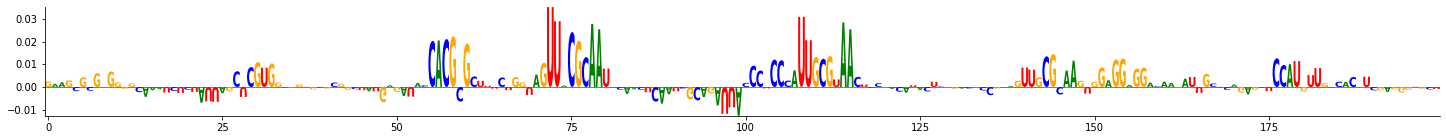

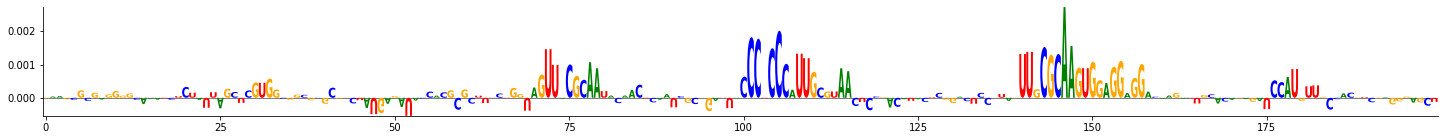

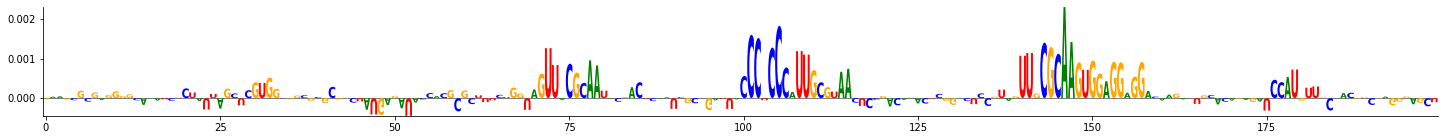

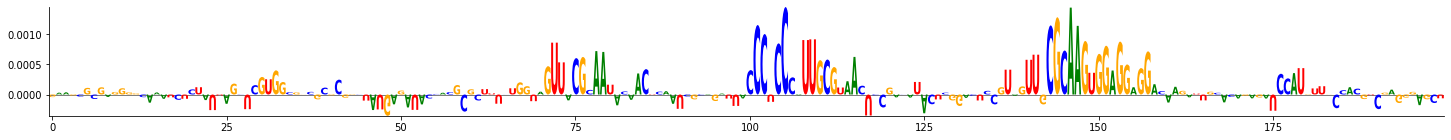

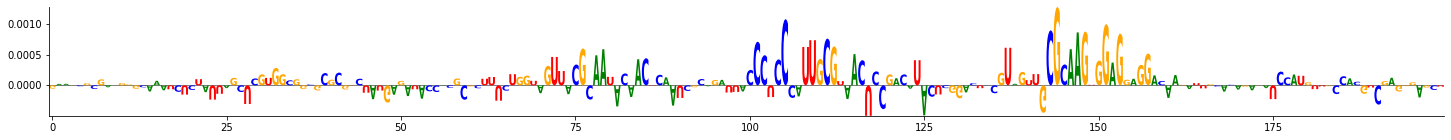

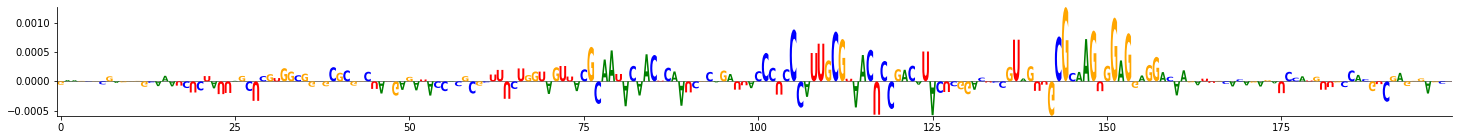

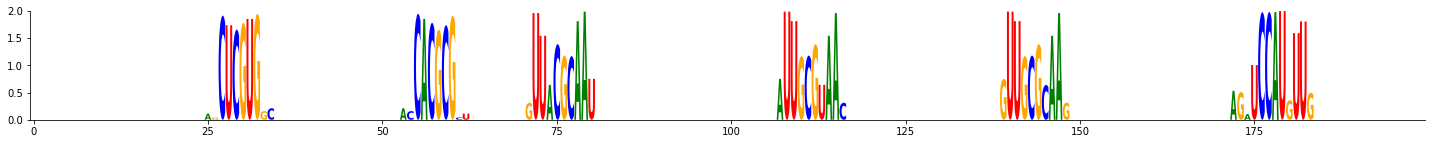

In [ ]:
# PLOT for p=-0.500 parameter 
import logomaker 
s=57 #Pick a sequence 42

N, L, A = attr_score3_AVERAGE.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score3_AVERAGE[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score6[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


# PLOT for p=-0.333 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score3[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

# PLOT for p=0 parameter (default classical saliency)
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score1[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05))
    fig = plt.gcf()

# PLOT for p=+0.333 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score4[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

# PLOT for p=+0.500 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score5[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


# PLOT ground truth
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = X_model_normalized[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

In [ ]:
np.corrcoef(x,y)

array([[ 1.        , -0.95354183],
       [-0.95354183,  1.        ]])

In [ ]:
motif = np.array ([[0,1,0,0],[1,0,0,0],[0,1,0,0], [0,0,1,0],[0,0,0,1],[0,0,1,0]])  #MAX  CACGTG
motif_length = len(motif)
print (motif)


motif_mark = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])-motif_length):
        if (np.sum(X[ii][jj:jj+motif_length] *motif)== motif_length ):  motif_mark[ii][jj:jj+motif_length]=1*X[ii][jj:jj+motif_length]

[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]]


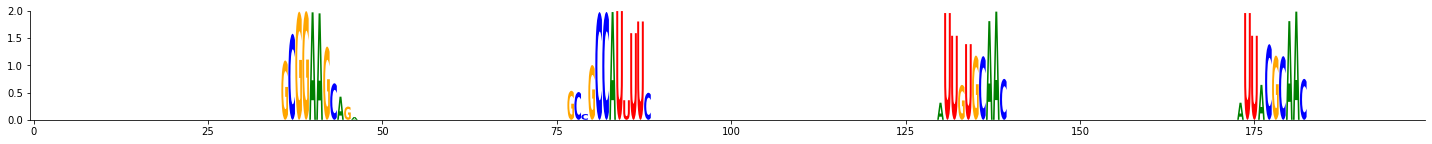

In [ ]:
# PLOT for p=-0.500 parameter 
import logomaker 
s=7 #Pick a sequence



# PLOT ground truth
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = X_model_normalized[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

In [ ]:
print(np.round(saliency_map_raw_AVERAGE[56]*1000),0)

[[  -3.   -2.    1.    2.]
 [   3.   -7.    5.   -3.]
 [   4.   -5.    1.    3.]
 [  -3.    2.    7.    2.]
 [   7.    2.    4.   -6.]
 [  -2.   12.   -4.   -5.]
 [  10.   -0.   -5.   -1.]
 [  -9.  -18.   26.    1.]
 [ -15.    1.   14.   -2.]
 [  11.   -2.   -1.    4.]
 [  23.  -10.   -1.   -7.]
 [  -3.   -2.    7.    2.]
 [  -4.    6.    7.    2.]
 [  -7.    4.   21.   -0.]
 [  10.    3.   12.   -2.]
 [   8.    5.    0.    6.]
 [  -0.  -18.   15.   19.]
 [ -10.   10.    3.    0.]
 [   5.   -4.    4.   15.]
 [   3.    1.   -3.   27.]
 [  -5.   28.  -15.   -3.]
 [  24.   14.   11.  -10.]
 [   2.   15.   52.  -29.]
 [ -61.  170.  -51.  -85.]
 [ 168.  -58.  -66.  -71.]
 [ -24.  160. -156.  -19.]
 [ -28. -166.  154.  -37.]
 [ -38.  -58.  -71.  136.]
 [ -49.  -88.  149.  -61.]
 [ -46.   34.   45.    8.]
 [  -2.    6.    6.   34.]
 [  18.    3.   10.   18.]
 [  -1.    8.   20.   -4.]
 [  10.    5.   -4.   18.]
 [  -4.    8.    6.   15.]
 [   8.   10.    8.   -1.]
 [   1.    8.   13.   -5.]
 

NOVO   NOVO    NOVO   NOVO

In [ ]:
count=[0]*n_components
for i in range (0, n_components):
    for j in range (0, len(labels)):  
        if (labels[j]==i): count[i]+=1

print(count)


[22, 107, 3, 81]


In [ ]:
z_line = [np.linspace(-1, 1, 5000)]*n_components
x_line = z_line * np.expand_dims( gm.means_[:,0], axis =1)
y_line = z_line * np.expand_dims(gm.means_[:,1], axis=1)

In [ ]:
count=[0]*n_components
distance=[0]*n_components
for i in range (0, n_components):
    for j in range (0, len(labels)):  
        if (labels[j]==i): 
            count[i]+=1
            distance[i]+=np.sqrt(np.sum(np.square(PPP[j,:]-centers[i,:])))
    distance[i]=distance[i]/count[i]
print(count)
print(distance)
print(np.sum(distance))

[22, 107, 3, 81]
[2.436456266313416, 0.2984148424070947, 1.4301684793710008, 0.7028151549872204]
4.867854743078732


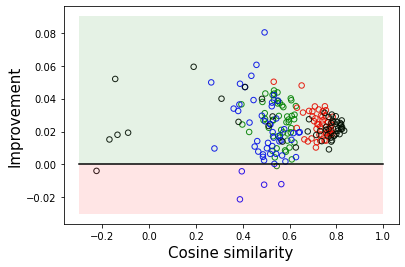

In [ ]:
'''# Saliency Cosine
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (-0.3, 0), 1.3, 0.09, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (-0.3, 0), 1.3, -0.03, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_relu'], SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_exponential'], SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_relu'], SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu']))

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_exponential'], SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential']))


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(-0.3, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Cosine similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
#plt.savefig('drive/My Drive/results/Cosine_Saliency.pdf')  
plt.show()

OTHER 4 Peformance vs Interpretability figures (the other 2 are at Octopus Automated Pipeline )

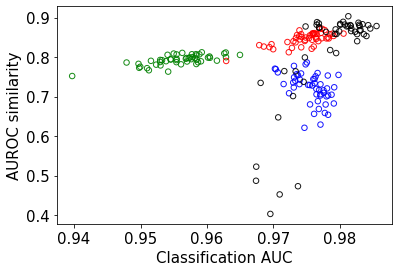

In [ ]:
# SaliencyAUROC
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, 0.9, facecolor = 'green', fill=True , alpha=0.1 ) )
#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, -0.3, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_relu'], SAL_AUROC['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_exponential'], SAL_AUROC['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_relu'], SAL_AUROC['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_exponential'], SAL_AUROC['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.92, 1.0, 100)
#ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Classification AUC', fontsize=15)
plt.ylabel('AUROC similarity', fontsize=15)
plt.savefig('drive/My Drive/results/Performance_VS_SaliencyAUROC.pdf')  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

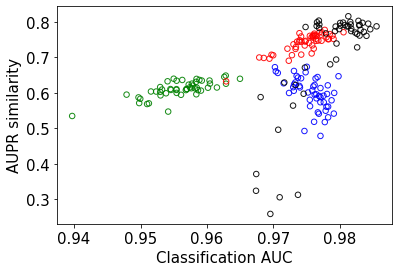

In [ ]:
# SaliencyAUPR
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, 0.9, facecolor = 'green', fill=True , alpha=0.1 ) )
#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, -0.3, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_relu'], SAL_AUPR['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_exponential'], SAL_AUPR['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_relu'], SAL_AUPR['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_exponential'], SAL_AUPR['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.92, 1.0, 100)
#ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Classification AUC', fontsize=15)
plt.ylabel('AUPR similarity', fontsize=15)
plt.savefig('drive/My Drive/results/Performance_VS_SaliencyAUPR.pdf')  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

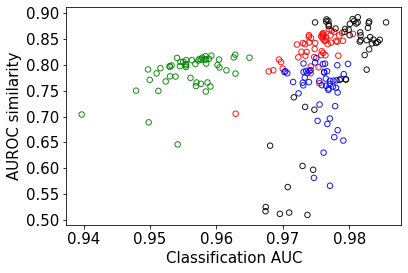

In [ ]:
# IG-AUROC
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, 0.9, facecolor = 'green', fill=True , alpha=0.1 ) )
#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, -0.3, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_relu'], IG_AUROC['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_exponential'], IG_AUROC['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_relu'], IG_AUROC['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_exponential'], IG_AUROC['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.92, 1.0, 100)
#ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Classification AUC', fontsize=15)
plt.ylabel('AUROC similarity', fontsize=15)
plt.savefig('drive/My Drive/results/Performance_VS_IgAUROC.pdf')  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

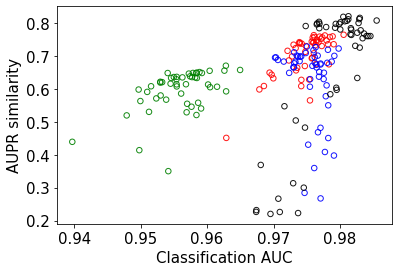

In [ ]:
# IG-AUPR
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, 0.9, facecolor = 'green', fill=True , alpha=0.1 ) )
#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, -0.3, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_relu'], IG_AUPR['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_exponential'], IG_AUPR['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_relu'], IG_AUPR['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_exponential'], IG_AUPR['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.92, 1.0, 100)
#ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Classification AUC', fontsize=15)
plt.ylabel('AUPR similarity', fontsize=15)
plt.savefig('drive/My Drive/results/Performance_VS_IgAUPR.pdf')  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
print('refresh')

refresh
